In [1]:
import xarray as xr
import dask
import numpy as np
from datetime import datetime, timedelta
from cartopy.feature.nightshade import Nightshade
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os, glob, sys, gc
import tqdm.auto as tqdm
import pandas as pd

/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [173]:
import argparse
import glob
import os
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import xarray as xr

import importlib

import warnings

In [3]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [4]:
from dask.diagnostics import ProgressBar

In [5]:
sys.path.append('/glade/u/home/abukowski/SAMI3-GITM-python/')

In [6]:
import utility_programs.filters as filters
from utility_programs.plotting_routines import panel_plot
from utility_programs.read_routines.GITM import auto_read as auto_read_gitm
from utility_programs.read_routines.GITM import gitm_times_from_filelist
from utility_programs.read_routines.SAMI import auto_read as auto_read_sami
from utility_programs import plotting_routines
from utility_programs.utils import ut_to_lt
from utility_programs.utils import add_lt_to_dataset

/glade/u/home/abukowski/SAMI3-GITM-python/utility_programs/plotting_routines.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


In [7]:
data = '/glade/u/home/abukowski/scratch/postprocessed/'

data+='MONTH_full_utHOUR_storm-on_MODEL.nc'

In [8]:
gitms = {}

for i in ['6','12','18']:
    gitms['may_'+'ut'+i] = xr.open_mfdataset(
        data.replace('MONTH','may').replace('HOUR',i).replace('MODEL','GITM'), engine='h5netcdf')
    gitms['nov_'+'ut'+i] = xr.open_mfdataset(
        data.replace('MONTH','nov').replace('HOUR',i).replace('MODEL','GITM'), engine='h5netcdf')


In [9]:
t_starts = {'ut6':'04:00:00', 'ut12':'10:00:00', 'ut18':'16:00:00'}

for k in gitms.keys():
    key = k[k.rfind('_')+1:]
    t_start = gitms[k].time.values[0] + pd.Timedelta('1 day' + t_starts[key])
    t_end = t_start + pd.Timedelta('8 hours')
    
    gitms[k] = gitms[k].sel(time = slice(t_start, t_end))
    

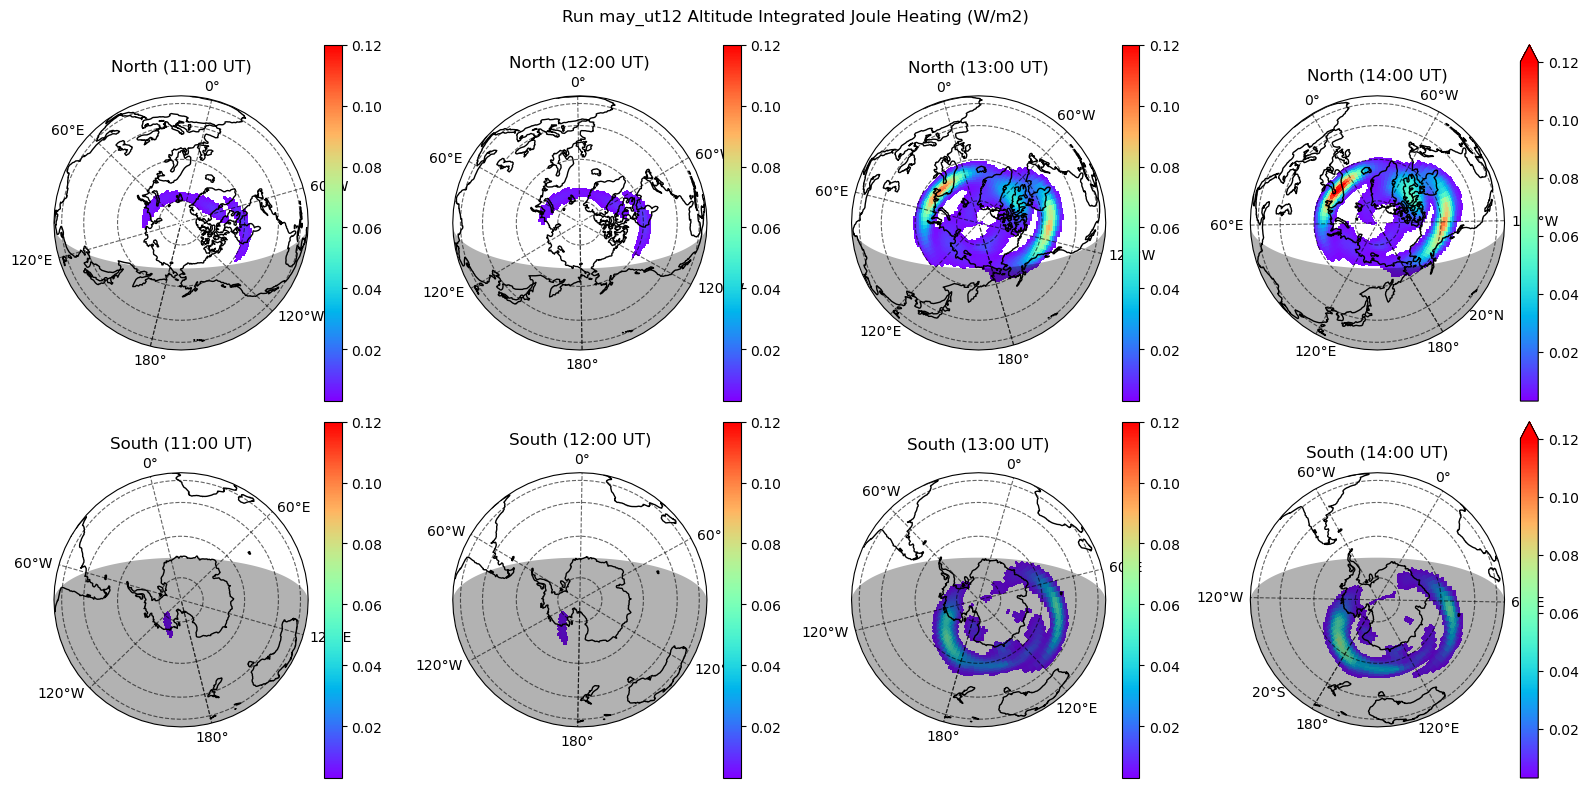

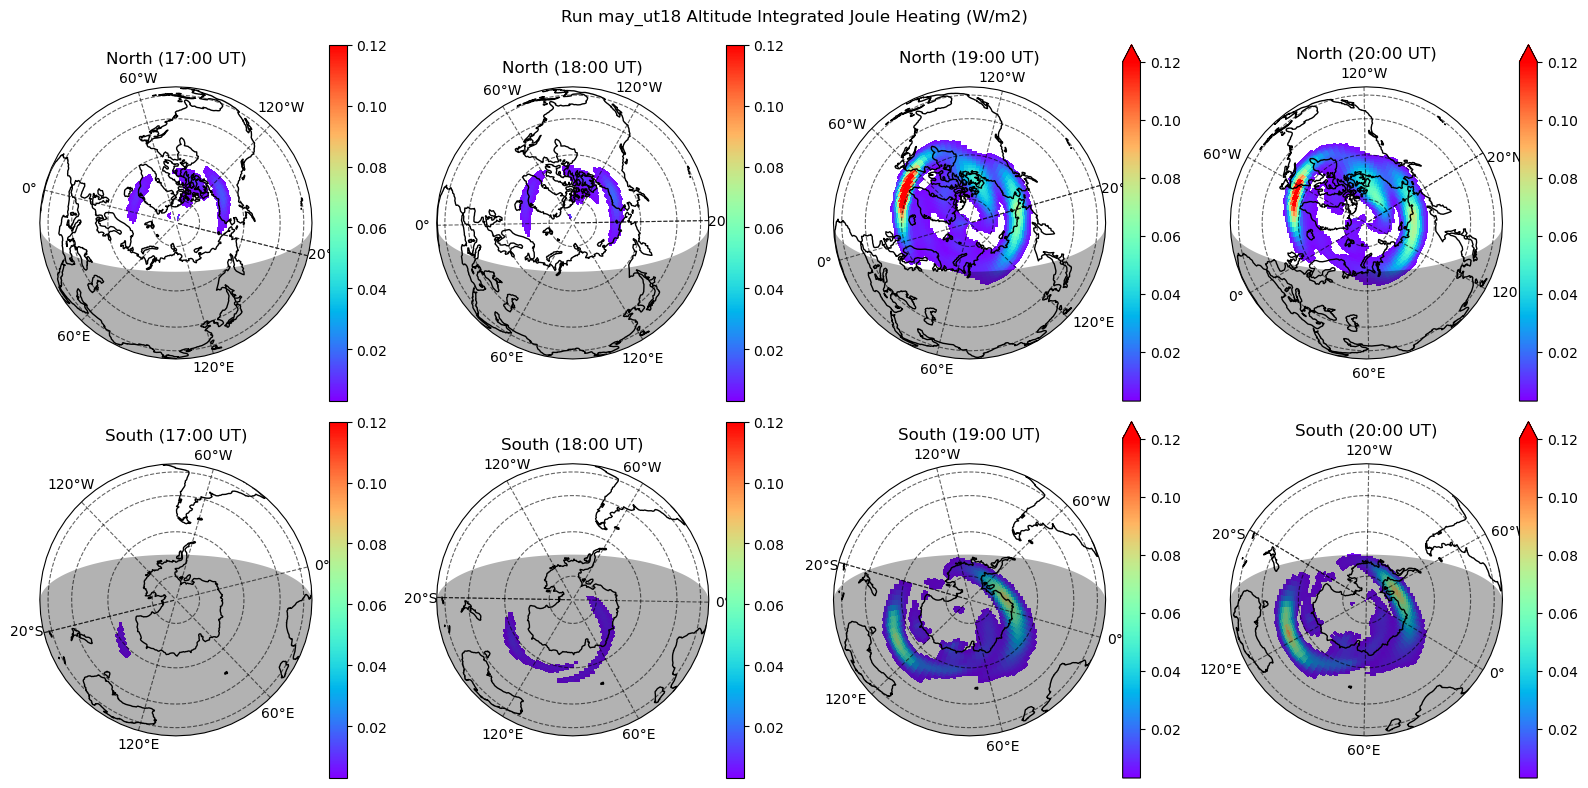

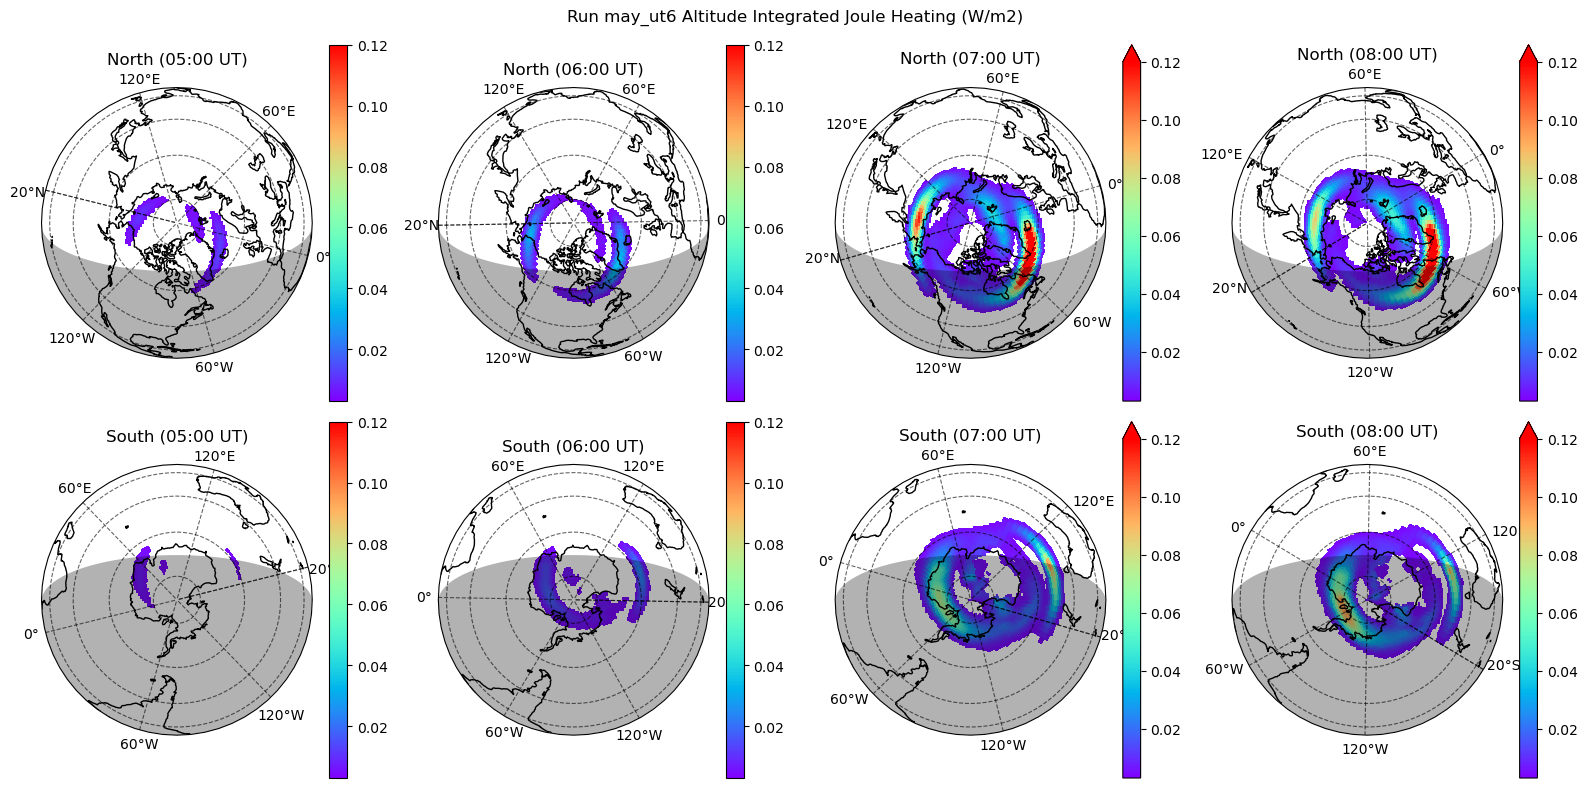

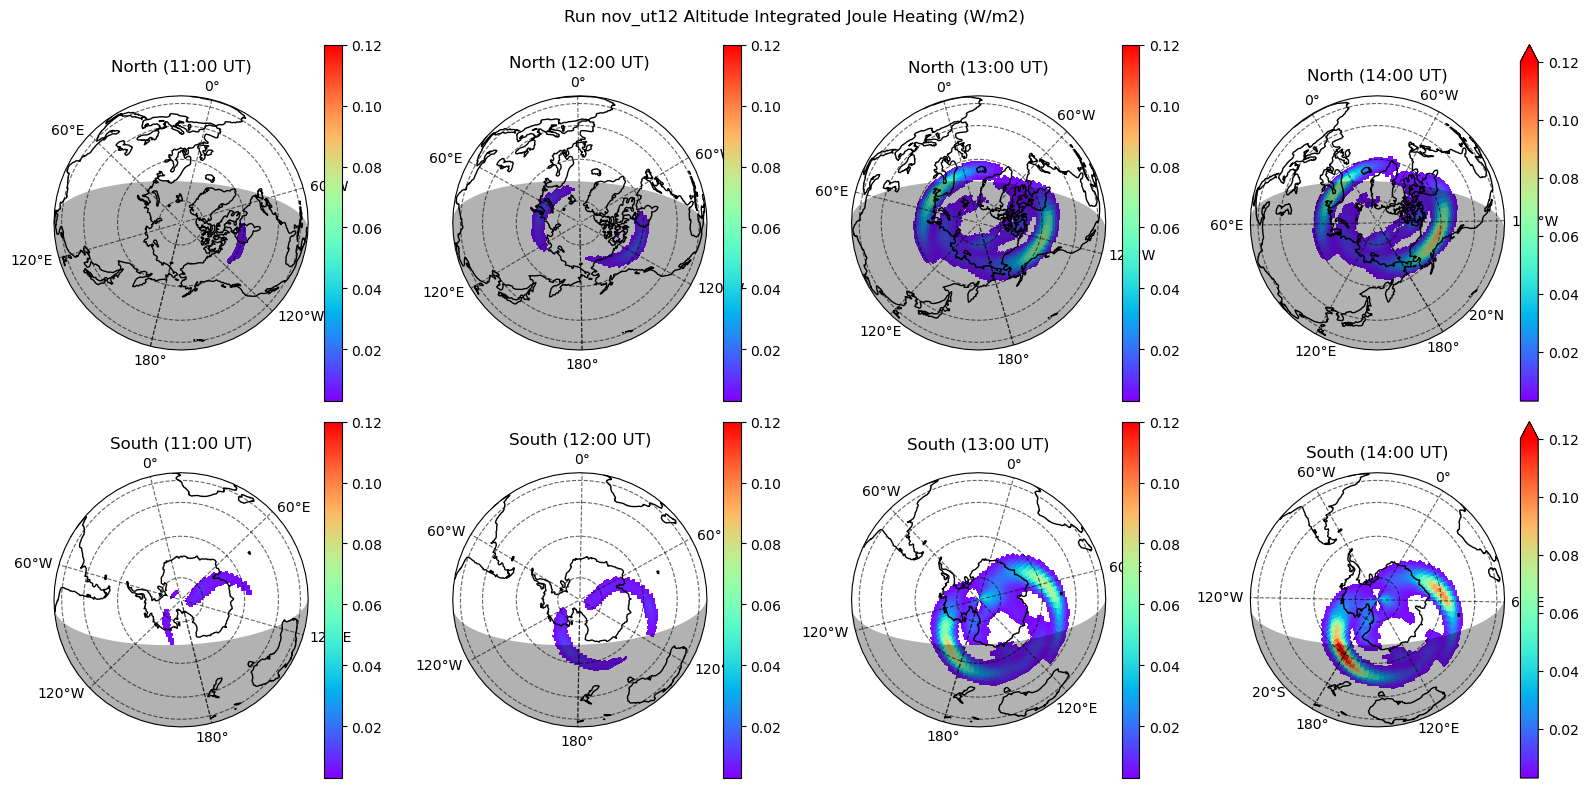

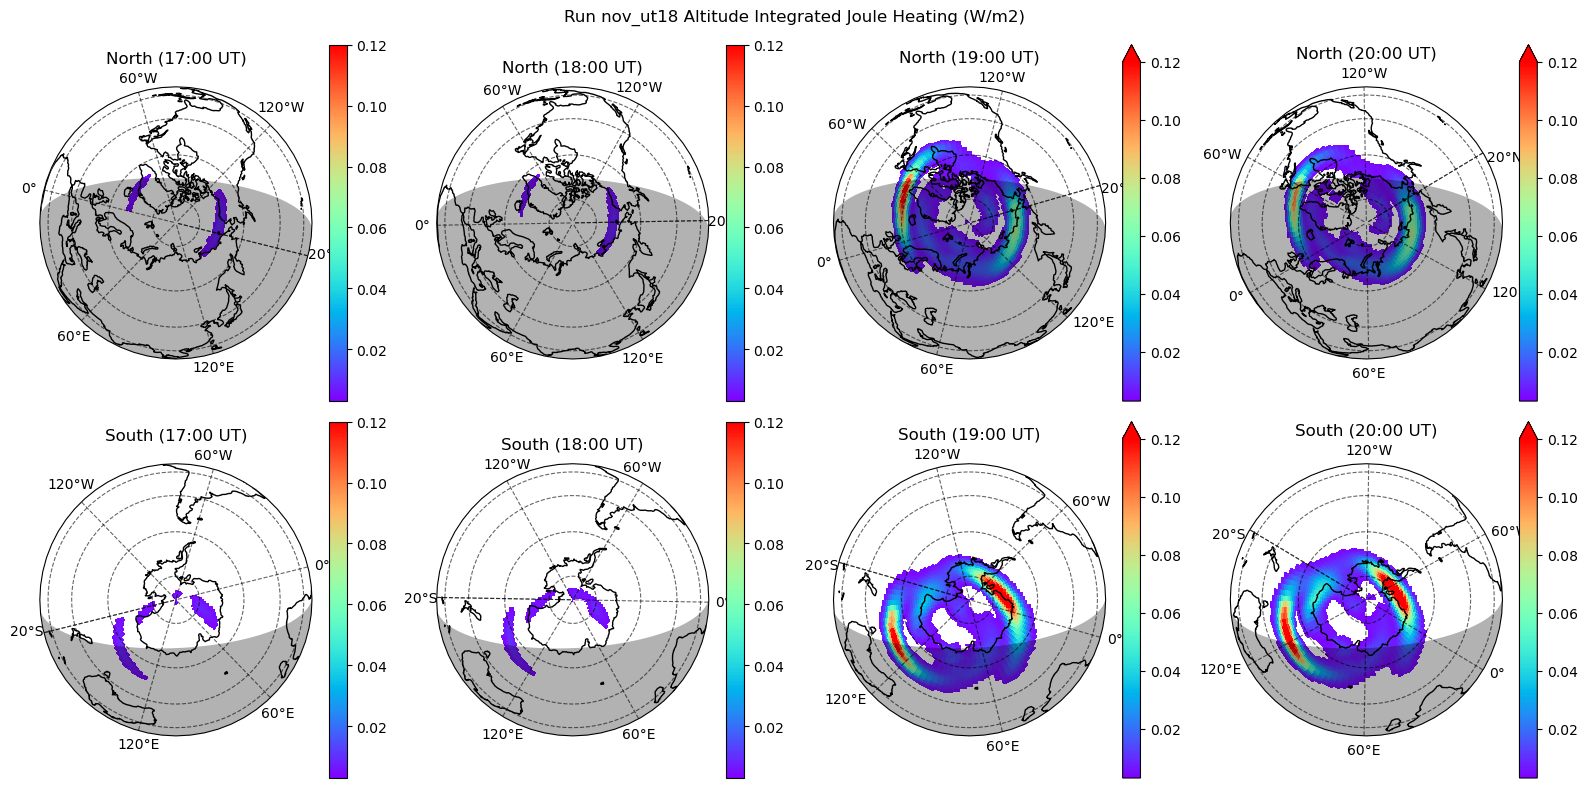

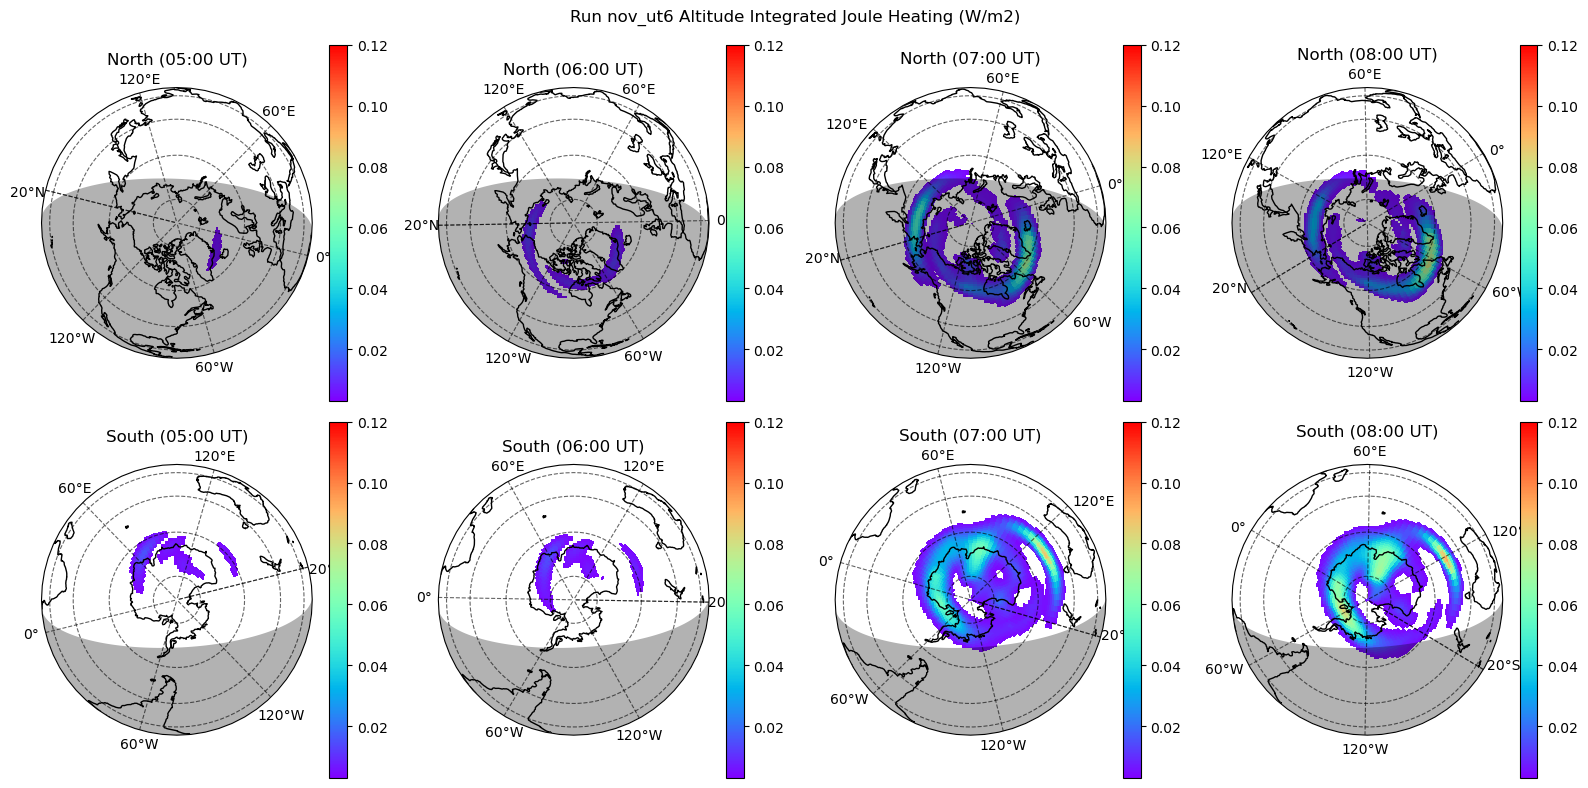

In [31]:
jh_figs = []
jh_fignames = []
for run in np.sort(list(gitms.keys())):
    
#     vmin = gitms[run].AltIntJouleHeating_W_m2.min().compute()
#     vmax = gitms[run].AltIntJouleHeating_W_m2.max().compute()

    suptitle='Run %s Altitude Integrated Joule Heating (W/m2)' %run
    
    jh_figs.append(plotting_routines.loop_panels(gitms[run].AltIntJouleHeating_W_m2, 4,
                                                 start_time=gitms[run].time[0].values + pd.Timedelta('1 hour'),
                                                 time_delta='1 hours',
                                                 suptitle=suptitle,
                                                 cmap='rainbow',
                                                     lon_labels=True,
                                                 vmin=.003, vmax=0.12,
                                                 mask_dials=0.004))
    jh_figs[-1].tight_layout()
    # jh_figs[-1].show()
    jh_fignames.append(run)
    
for fig in range(len(jh_figs)):
    jh_figs[fig].savefig('/glade/u/home/abukowski/plots/cedar/exploring/ut/jh_dials/' +jh_fignames[fig]);


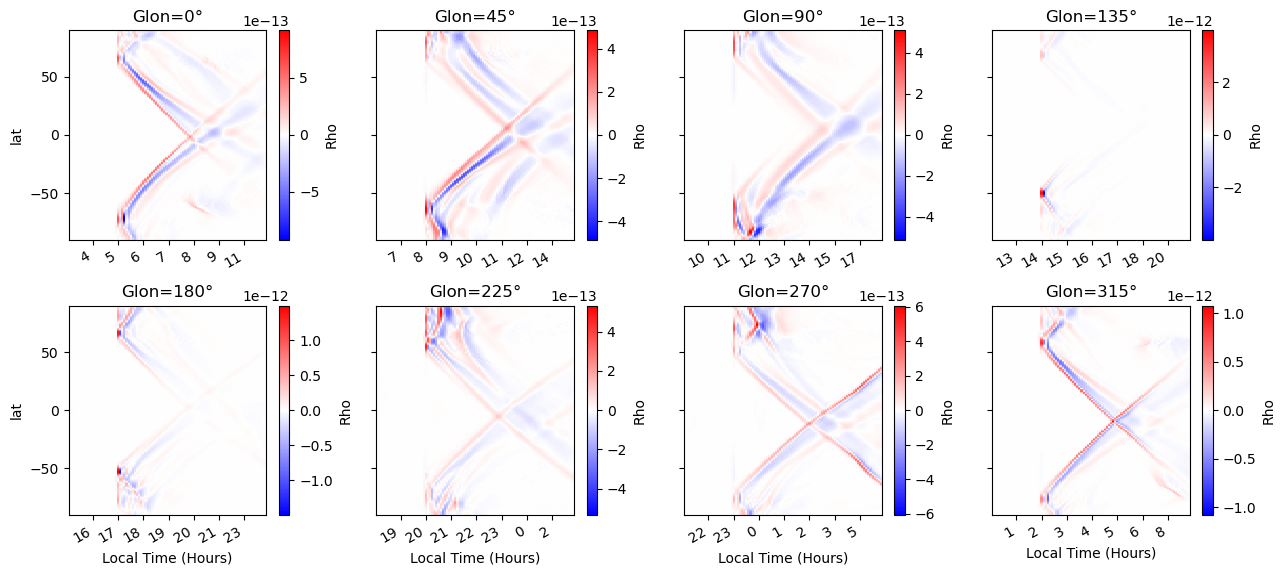

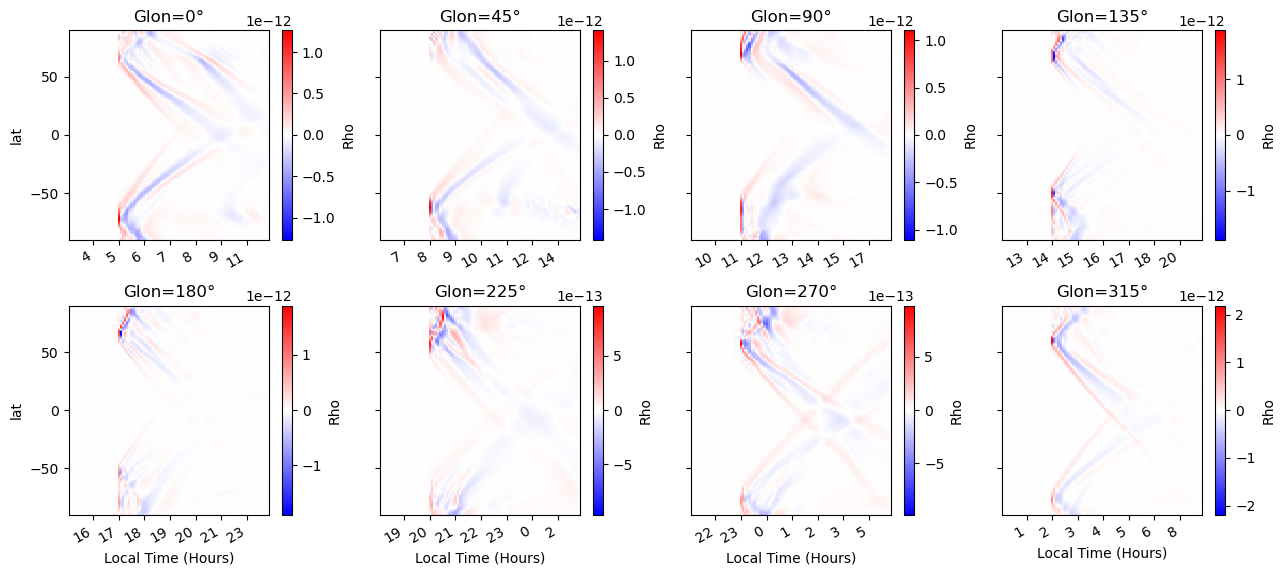

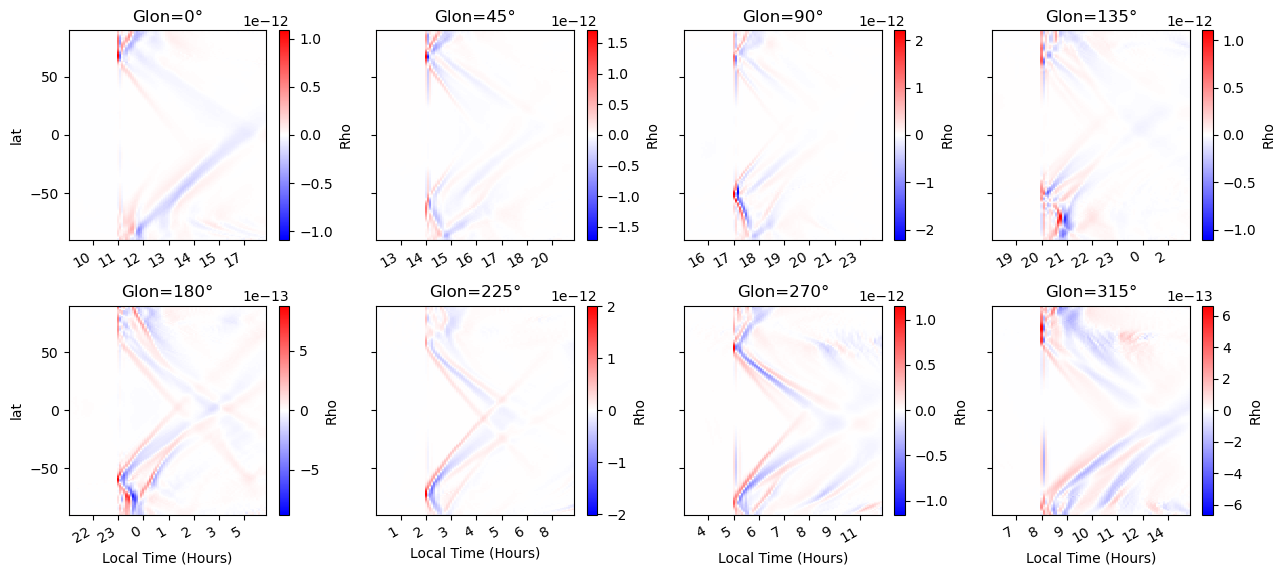

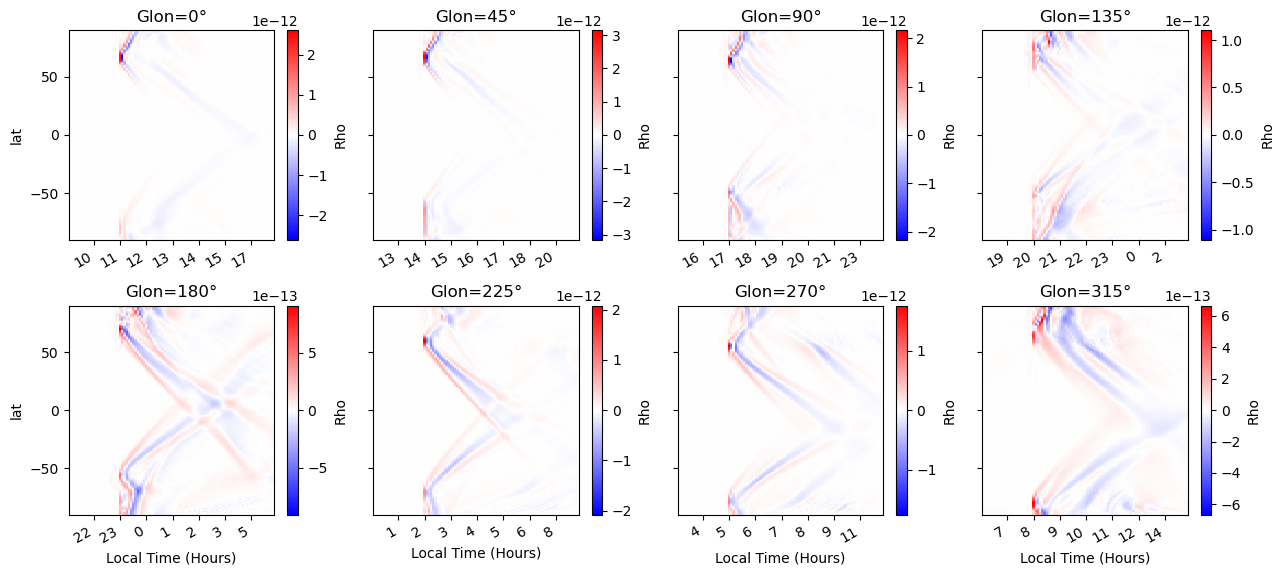

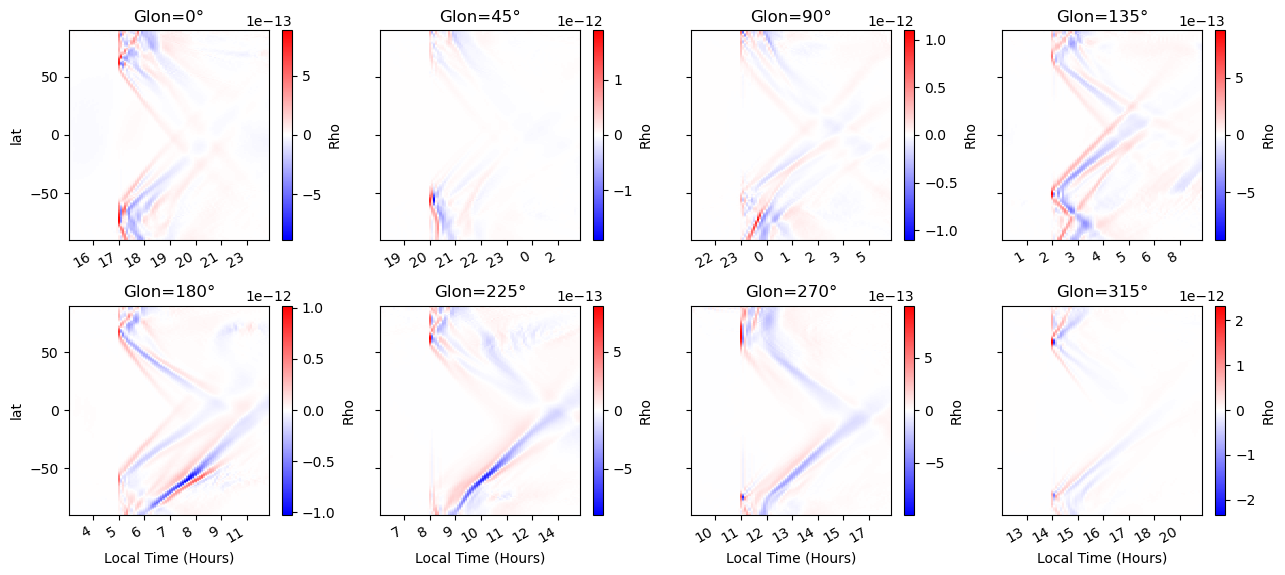

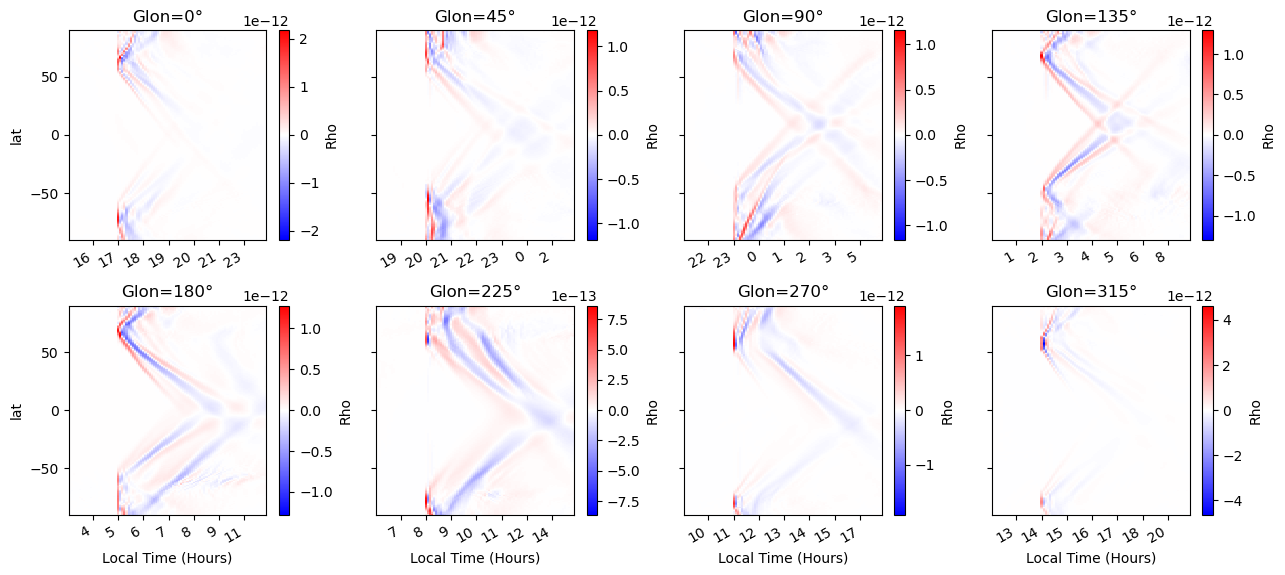

In [ ]:
for run in gitms.keys():
    plotting_routines.panel_with_lt(
        filters.filter_xarray_DA_diff(gitms[run].Rho.sel(alt=350, method='nearest')),
        tight_layout=True)

In [ ]:
filters.filter_xarray_DA_diff(add_lt_to_dataset(gitms[run].Rho.sel(alt=350, method='nearest'),
                  localtimes = 90).sel(localtime=np.linspace(0,24,8), method='nearest')).plot(
    col='localtime', col_wrap = 4, x='time', cmap='bwr')

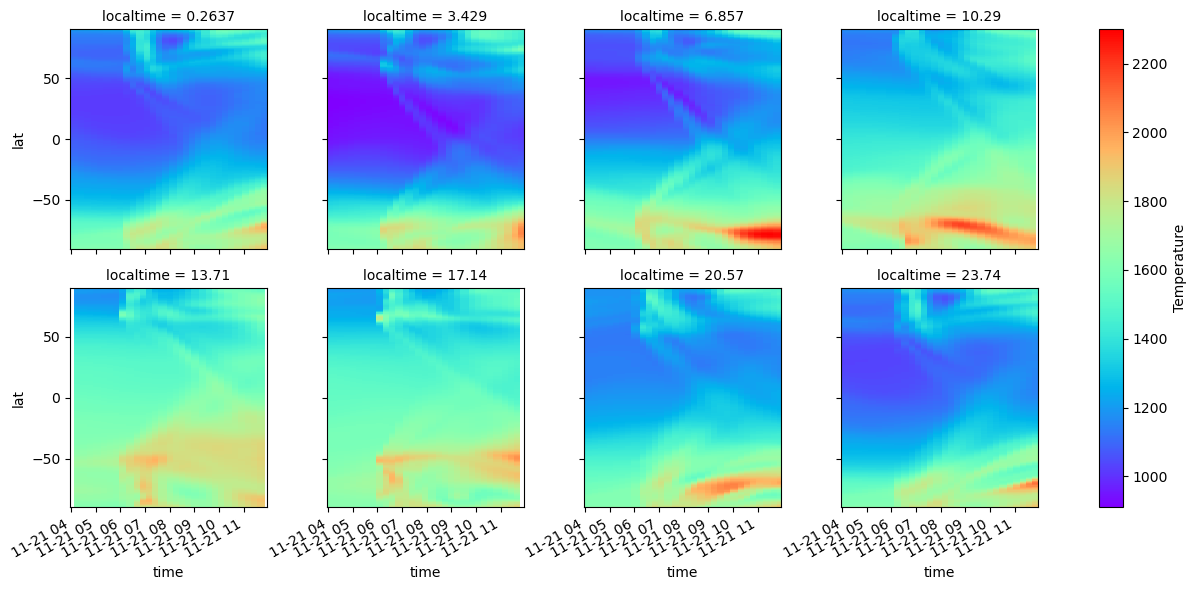

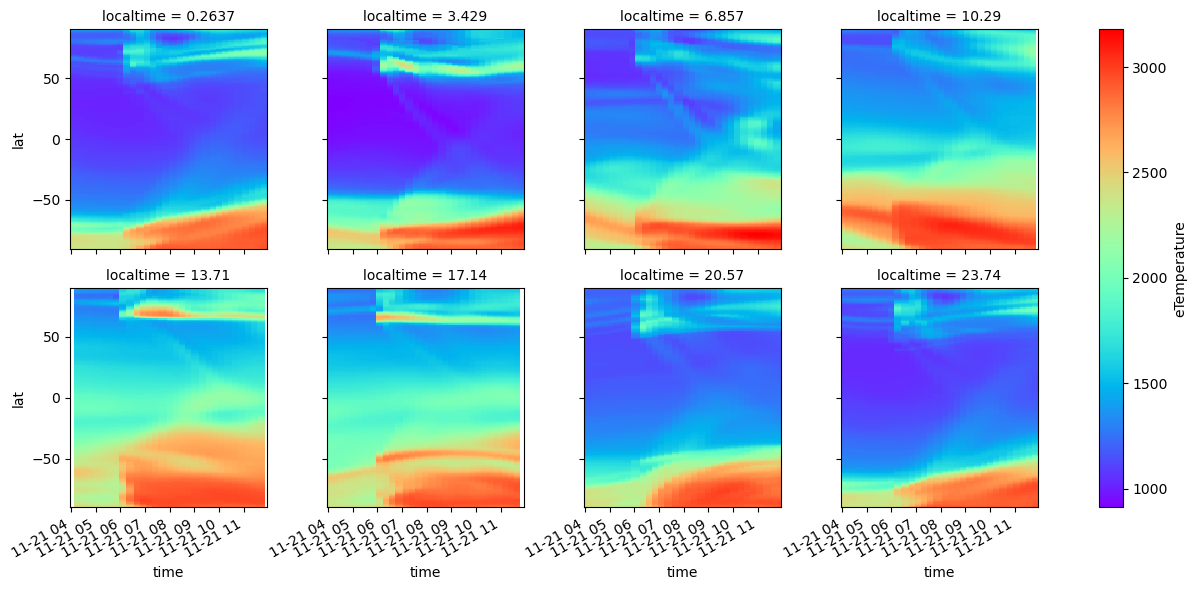

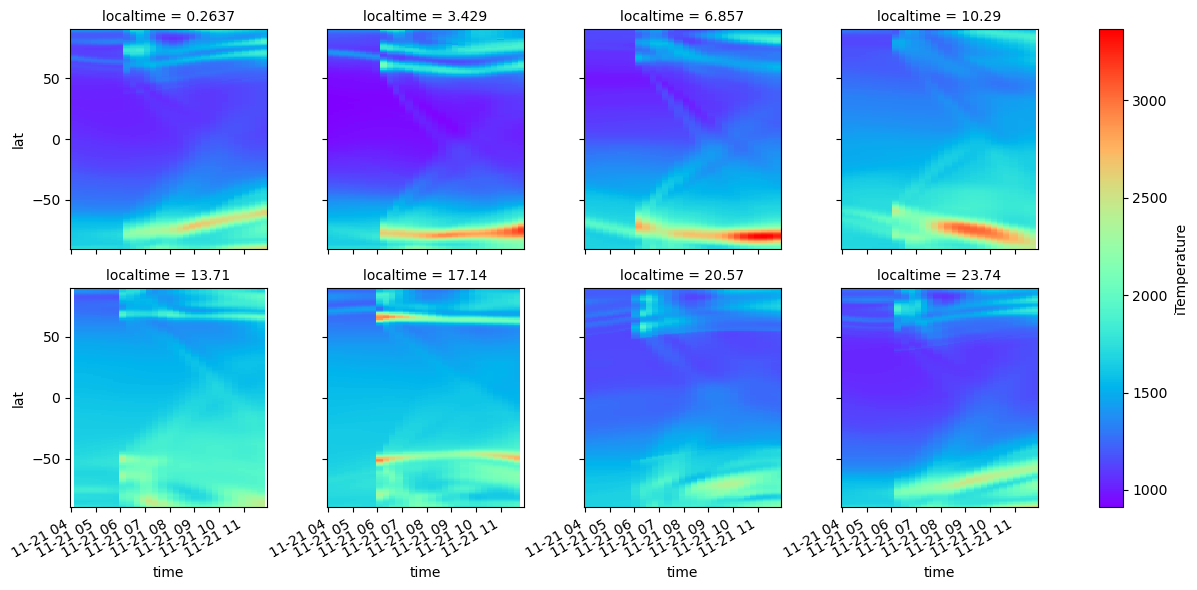

In [48]:
add_lt_to_dataset(gitms[run].Temperature.sel(alt=350, method='nearest'),
                  localtimes = 90).sel(localtime=np.linspace(0,24,8), method='nearest').plot(
    col='localtime', col_wrap = 4, x='time', cmap='rainbow')

add_lt_to_dataset(gitms[run].eTemperature.sel(alt=350, method='nearest'),
                  localtimes = 90).sel(localtime=np.linspace(0,24,8), method='nearest').plot(
    col='localtime', col_wrap = 4, x='time', cmap='rainbow')

add_lt_to_dataset(gitms[run].iTemperature.sel(alt=350, method='nearest'),
                  localtimes = 90).sel(localtime=np.linspace(0,24,8), method='nearest').plot(
    col='localtime', col_wrap = 4, x='time', cmap='rainbow')

In [149]:
gc.collect()

1245

In [329]:

def custom_panels_keos(da,
                       numplots=8,
                       sel_col='localtime',
                       max_per_row=4,
                       suptitle=None,
                       vmin=None,
                       vmax=None,
                       sharex=True,
                       sharey=True,
                       x='time',
                       cmap='rainbow',
                       single_colorbar=True,
                       colorbar_label=''):

    if sel_col == 'localtime' and sel_col not in da.coords:
        # print('adding')
        da = add_lt_to_dataset(da, localtimes=90)
    # print(da.coords)
    # return da

    nrows = int(np.ceil(numplots/max_per_row))
    ncols = max_per_row

    f, axs = plt.subplots(nrows,
                          ncols,
                          figsize=(5*nrows, 1.3*ncols if suptitle is not None else 1*ncols),
                          sharey=sharey,
                          sharex=sharex)

    sel_list = np.linspace(da[sel_col].min().values,
                           da[sel_col].max().values,
                           numplots+2)[1:-1]
    
    if single_colorbar:
        if vmin is None:
            vmin = da.min().compute()
        if vmax is None:
            vmax = da.max().compute()
            
    for a, ax in enumerate(axs.flatten()):
        ims = da.sel({sel_col: sel_list[a]}, method='nearest').plot(
            x=x, ax=ax, cmap=cmap,vmin=vmin, vmax=vmax, add_colorbar=not single_colorbar)
        
    if single_colorbar:
        divider = make_axes_locatable(axs[nrows-1, ncols-1])
        cax = divider.append_axes('right', size='5%', pad=0.05, in_layout=True)
        f.colorbar(ims, cax=cax, orientation='vertical', label=colorbar_label)

        divider = make_axes_locatable(axs[0, ncols-1])
        cax = divider.append_axes('right', size='5%', pad=0.05, in_layout=True)
        f.colorbar(ims, cax=cax, orientation='vertical', label=colorbar_label)

    if suptitle is not None:
        f.suptitle(suptitle)
    f.tight_layout()

    return f

0:00:01.909095


datetime.timedelta(seconds=1, microseconds=909256)

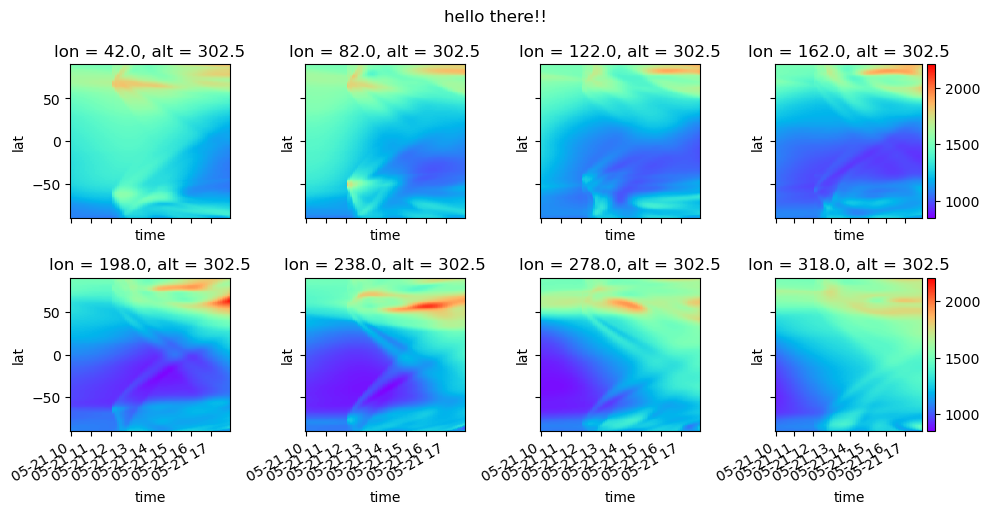

In [330]:
l = datetime.now()

fig= custom_panels_keos(gitms['may_ut12'].Temperature.sel(alt=300,method='nearest'), sel_col='lon',
                          single_colorbar=True, suptitle='hello there!!');
fig.show()

fig.savefig('/glade/u/home/abukowski/test1')

print(datetime.now() - l)

# fig = custom_panels_keos(gitms['may_ut12'].Temperature.sel(alt=300,method='nearest'), sel_col='localtime',
#                           single_colorbar=True, suptitle='hello there!!');
# fig.show()
# fig.savefig('/glade/u/home/abukowski/test2')
# fig = custom_panels_keos(gitms['may_ut12'].Temperature.sel(alt=300,method='nearest'), sel_col='localtime',
#                           single_colorbar=True, suptitle='hello there!!');
# fig.show()

datetime.now() - l

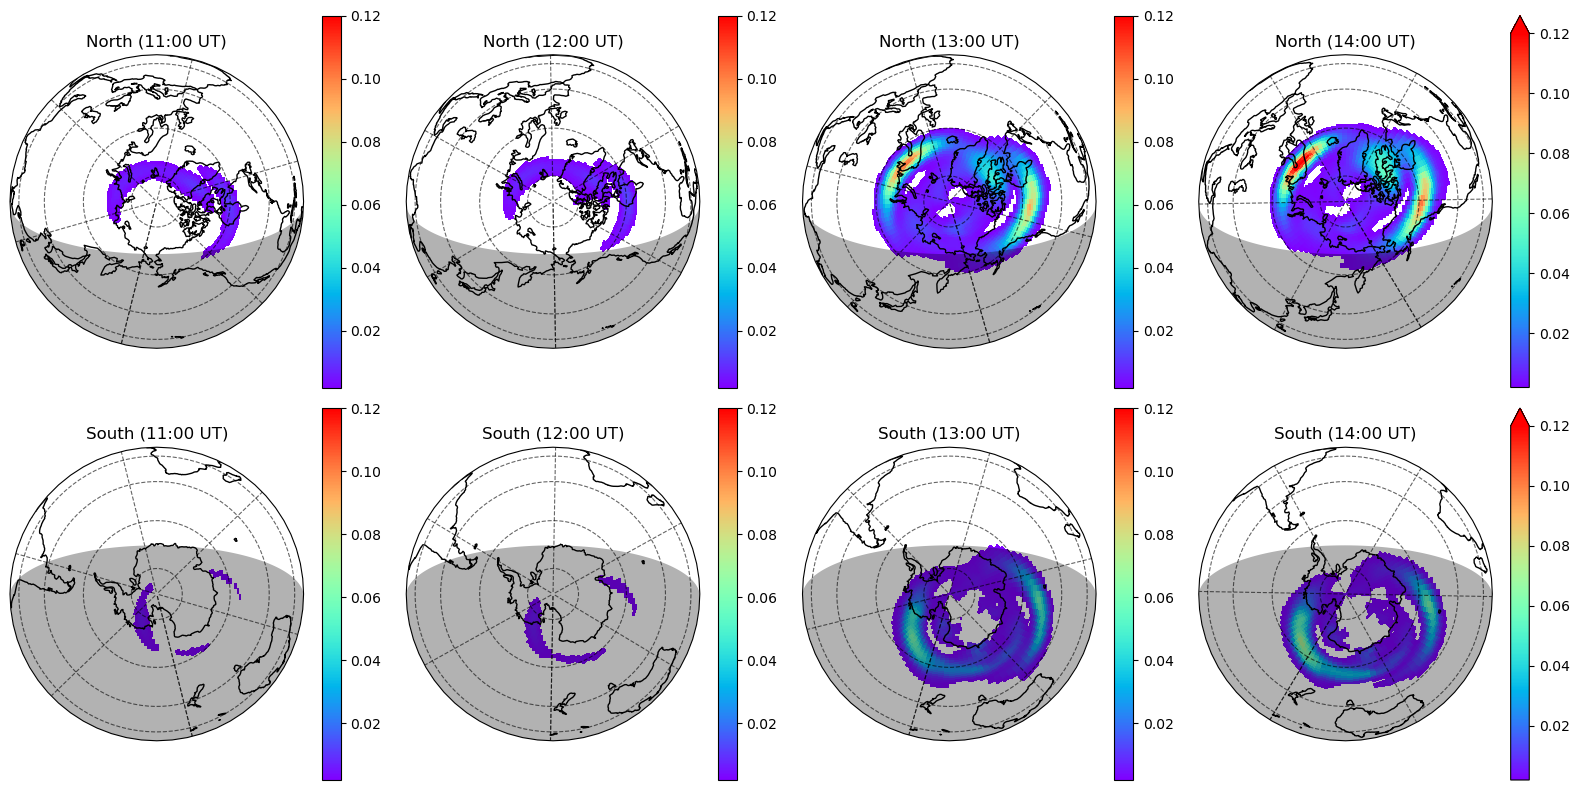

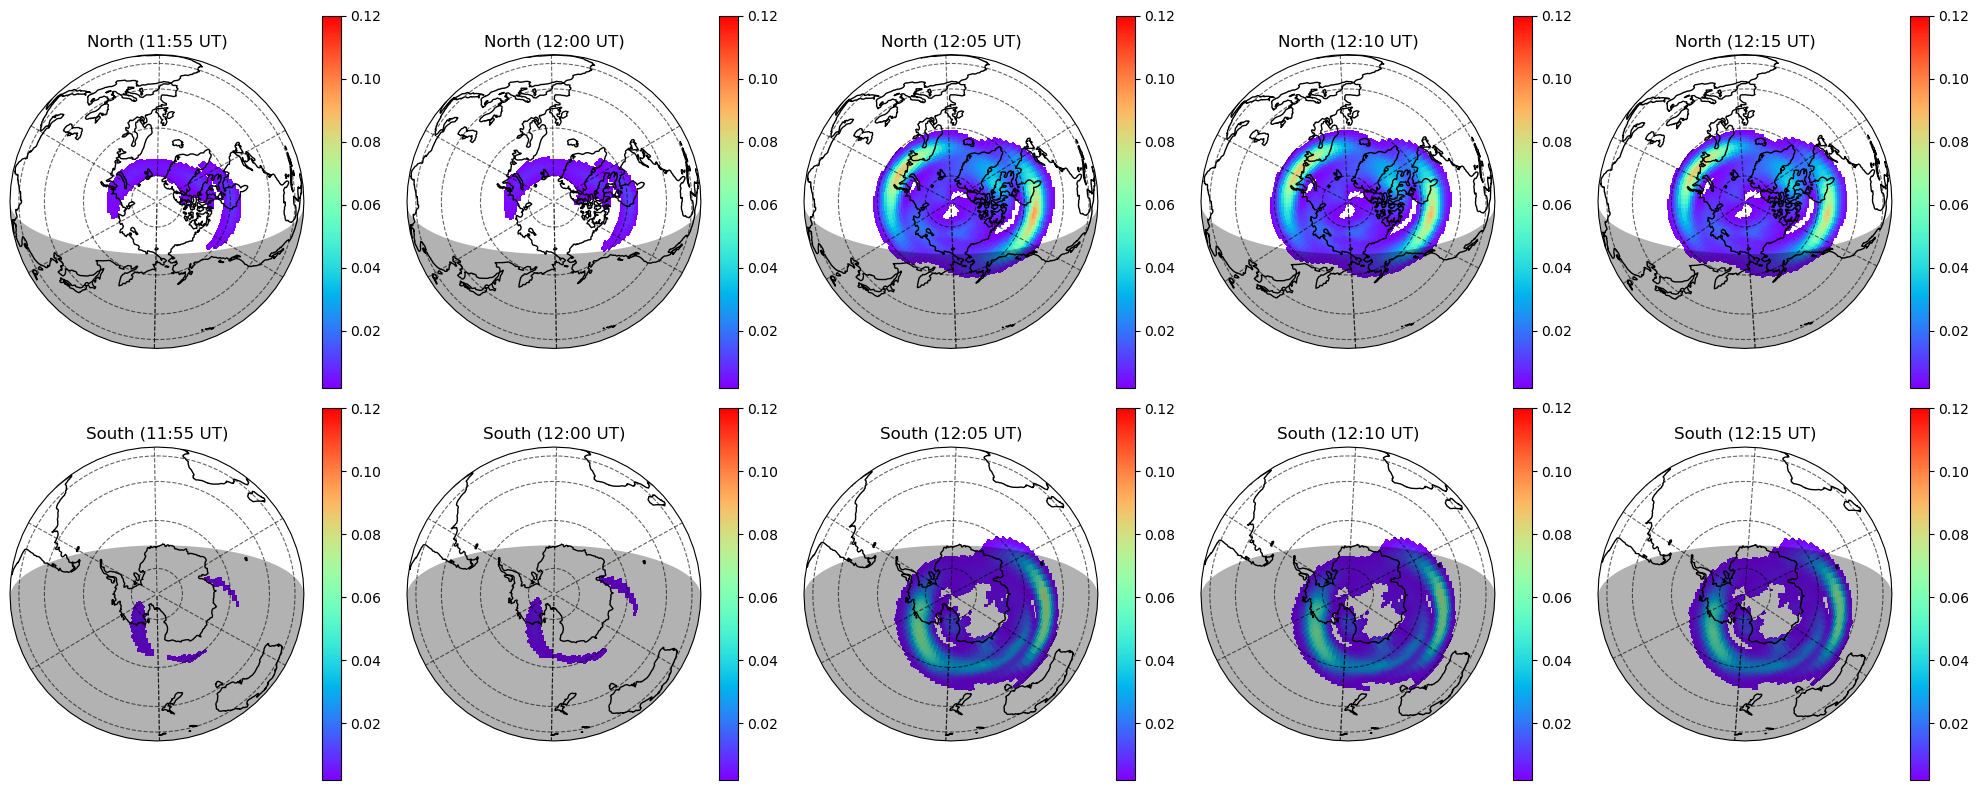

In [178]:
f = plotting_routines.loop_panels(gitms['may_ut12'].AltIntJouleHeating_W_m2, ncols=4, start_time='2011-05-21 11:00', mask_dials=.002, cmap='rainbow', vmax=.12)

f.show()

f = plotting_routines.loop_panels(gitms['may_ut12'].AltIntJouleHeating_W_m2, ncols=5,
                                  start_time='2011-05-21 11:55', time_delta='5 minutes',
                                  mask_dials=.002, cmap='rainbow', vmax=.12)
f.show()



In [331]:

bar = tqdm.tqdm(total=15*len(gitms.keys()))



for run, ds in gitms.items():

    suptitle = 'Mean Neutral Temperature in Altitude from Run ' + run
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig = custom_panels_keos(da=ds.Temperature.mean('alt'),
                                suptitle=suptitle)

    fig.savefig(
        '/glade/u/home/abukowski/plots/cedar/exploring/ut/temperature/alt-mean/'+run+'_neut')
    bar.update()

    suptitle = 'Mean Electron Temperature in Altitude from Run ' + run
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig = custom_panels_keos(da=ds.eTemperature.mean('alt'),suptitle=suptitle)
    

    fig.savefig(
        '/glade/u/home/abukowski/plots/cedar/exploring/ut/temperature/alt-mean/'+run+'_electron',)
    bar.update()

    suptitle = 'Mean Ion Temperature in Altitude from Run ' + run
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig = custom_panels_keos(ds.iTemperature.mean('alt'),
                                suptitle=suptitle)

    fig.savefig(
        '/glade/u/home/abukowski/plots/cedar/exploring/ut/temperature/alt-mean/'+run+'_ion')
    bar.update()

    for a in [150, 300, 500, 650]:
        for var in ['Temperature', 'iTemperature', 'eTemperature']:

            if var == 'Temperature':
                var_now = 'Neutral'
            elif var == 'eTemperature':
                var_now = 'Electron'
            elif var == 'iTemperature':
                var_now = 'Ion'
            else:
                raise ValueError

            suptitle = '%s Temperature at %i (km) Altitude from Run ' % (
                var_now, int(a)) + run
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                fig = custom_panels_keos(ds[var].sel(alt=a, method='nearest', drop=True),
                                suptitle=suptitle)

            # print(var_now)

            fig.savefig(
                '/glade/u/home/abukowski/plots/cedar/exploring/ut/temperature/alt-%i/' % int(a)+run+'_'+var_now)
            bar.update()
            
            
    plt.close('all')


  1%|          | 1/90 [56:19<83:32:52, 3379.47s/it]

100%|██████████| 90/90 [3:44:53<00:00, 147.93s/it]

In [126]:
ds

<xarray.DataArray 'Temperature' (localtime: 90, time: 96, lat: 180, alt: 50)>
dask.array<concatenate, shape=(90, 96, 180, 50), dtype=float64, chunksize=(1, 1, 180, 50), chunktype=numpy.ndarray>
Coordinates:
    lon        (localtime, time) float64 210.0 210.0 210.0 ... 86.0 86.0 82.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * alt        (alt) float64 100.0 101.7 103.5 105.4 ... 684.6 706.7 729.0 751.5
  * localtime  (localtime) float64 0.0 0.2637 0.5275 ... 22.95 23.21 23.47
  * time       (time) datetime64[ns] 2011-05-21T10:00:00.047000 ... 2011-05-2...

In [129]:
sels

[(Interval(0.5, 1.5, closed='right'), [2, 3, 4, 5]),
 (Interval(4.5, 5.5, closed='right'), [18, 19, 20]),
 (Interval(8.5, 9.5, closed='right'), [33, 34, 35, 36]),
 (Interval(12.5, 13.5, closed='right'), [48, 49, 50, 51]),
 (Interval(16.5, 17.5, closed='right'), [63, 64, 65, 66]),
 (Interval(20.5, 21.5, closed='right'), [78, 79, 80, 81])]

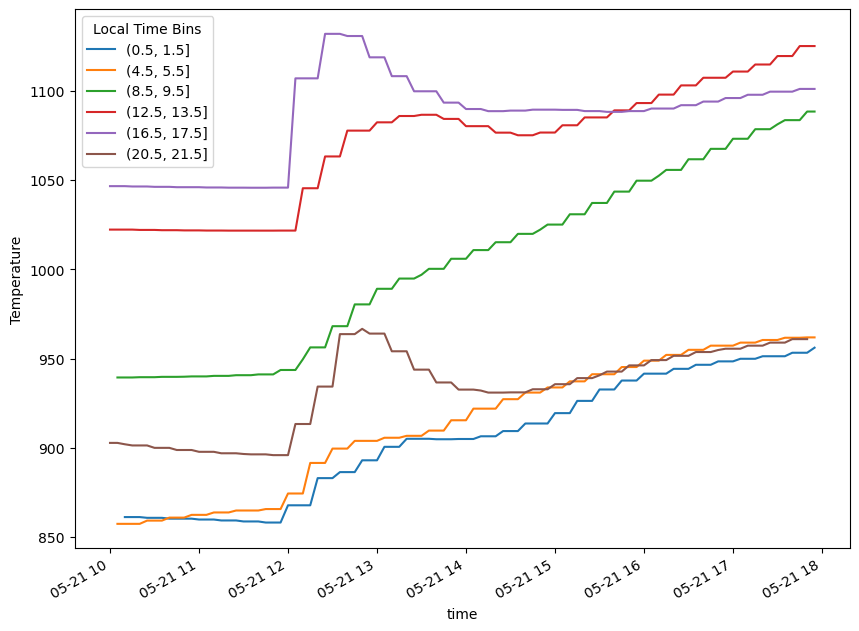

In [138]:
gitms.keys()

dict_keys(['may_ut6', 'nov_ut6', 'may_ut12', 'nov_ut12', 'may_ut18', 'nov_ut18'])

<xarray.DataArray 'minute' (time: 96)>
array([-120, -115, -110, -105, -100,  -95,  -90,  -85,  -80,  -75,  -70,
        -65, -120, -115, -110, -105, -100,  -95,  -90,  -85,  -80,  -75,
        -70,  -65, -120, -115, -110, -105, -100,  -95,  -90,  -85,  -80,
        -75,  -70,  -65, -120, -115, -110, -105, -100,  -95,  -90,  -85,
        -80,  -75,  -70,  -65, -120, -115, -110, -105, -100,  -95,  -90,
        -85,  -80,  -75,  -70,  -65, -120, -115, -110, -105, -100,  -95,
        -90,  -85,  -80,  -75,  -70,  -65, -120, -115, -110, -105, -100,
        -95,  -90,  -85,  -80,  -75,  -70,  -65, -120, -115, -110, -105,
       -100,  -95,  -90,  -85,  -80,  -75,  -70,  -65])
Coordinates:
  * time     (time) datetime64[ns] 2011-11-21T04:00:00.545000 ... 2011-11-21T...

<xarray.DataArray (time: 96)>
array([-2.        , -1.91666667, -1.83333333, -1.75      , -1.66666667,
       -1.58333333, -1.5       , -1.41666667, -1.33333333, -1.25      ,
       -1.16666667, -1.08333333, -1.        , -0.91666667, -0.83333333,
       -0.75      , -0.66666667, -0.58333333, -0.5       , -0.41666667,
       -0.33333333, -0.25      , -0.16666667, -0.08333333,  0.        ,
        0.08333333,  0.16666667,  0.25      ,  0.33333333,  0.41666667,
        0.5       ,  0.58333333,  0.66666667,  0.75      ,  0.83333333,
        0.91666667,  1.        ,  1.08333333,  1.16666667,  1.25      ,
        1.33333333,  1.41666667,  1.5       ,  1.58333333,  1.66666667,
        1.75      ,  1.83333333,  1.91666667,  2.        ,  2.08333333,
        2.16666667,  2.25      ,  2.33333333,  2.41666667,  2.5       ,
        2.58333333,  2.66666667,  2.75      ,  2.83333333,  2.91666667,
        3.        ,  3.08333333,  3.16666667,  3.25      ,  3.33333333,
        3.41666667,  3.5       ,  3.58333333,  3.66666667,  3.75      ,
        3.83333333,  3.91666667,  4.        ,  4.08333333,  4.16666667,
        4.25      ,  4.33333333,  4.41666667,  4.5       ,  4.58333333,
        4.66666667,  4.75      ,  4.83333333,  4.91666667,  5.        ,
        5.08333333,  5.16666667,  5.25      ,  5.33333333,  5.41666667,
        5.5       ,  5.58333333,  5.66666667,  5.75      ,  5.83333333,
        5.91666667])
Coordinates:
  * time     (time) datetime64[ns] 2011-11-21T04:00:00.545000 ... 2011-11-21T...

In [165]:
ds

<xarray.DataArray 'Temperature' (localtime: 90, time: 96, lat: 180, alt: 50)>
dask.array<concatenate, shape=(90, 96, 180, 50), dtype=float64, chunksize=(1, 1, 180, 50), chunktype=numpy.ndarray>
Coordinates:
    lon                  (localtime, time) float64 302.0 302.0 ... 174.0 174.0
  * lat                  (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * alt                  (alt) float64 100.0 101.7 103.5 ... 585.2 602.6 620.1
  * localtime            (localtime) float64 0.0 0.2637 0.5275 ... 23.21 23.47
  * time                 (time) datetime64[ns] 2011-05-21T04:00:00.453000 ......
    HoursFromStormOnset  (time) float64 -2.0 -1.917 -1.833 ... 5.75 5.833 5.917

100%|██████████| 6/6 [32:38<00:00, 326.40s/it]


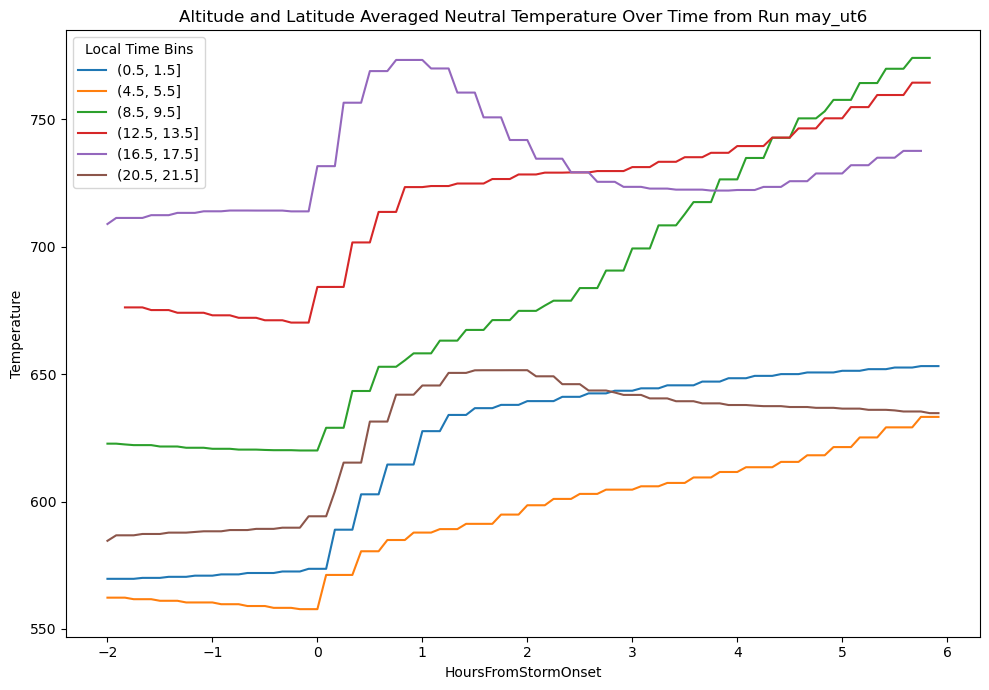

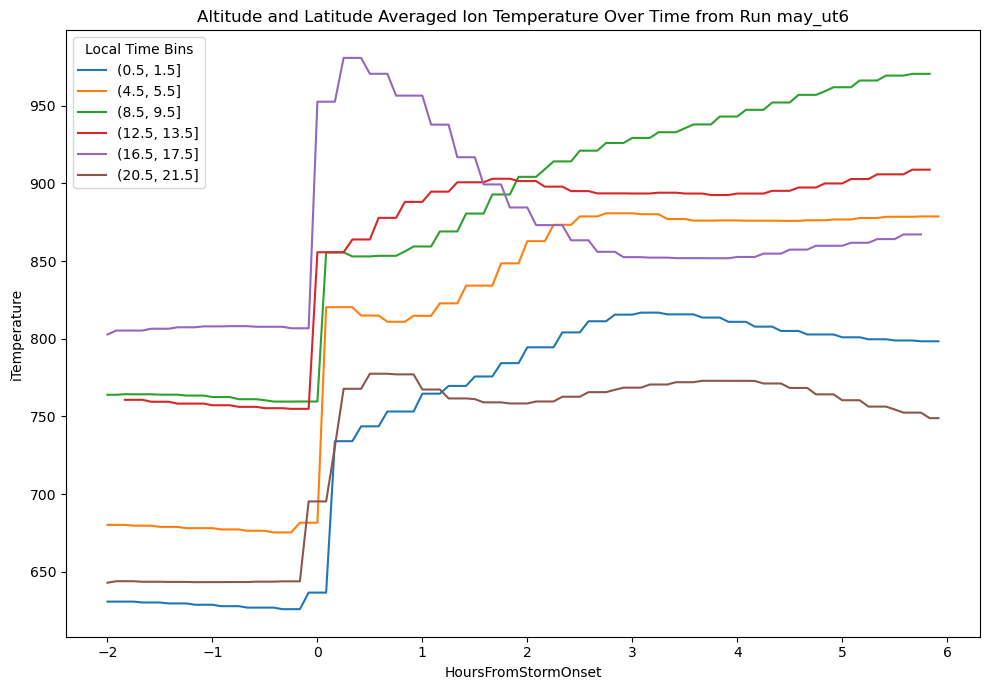

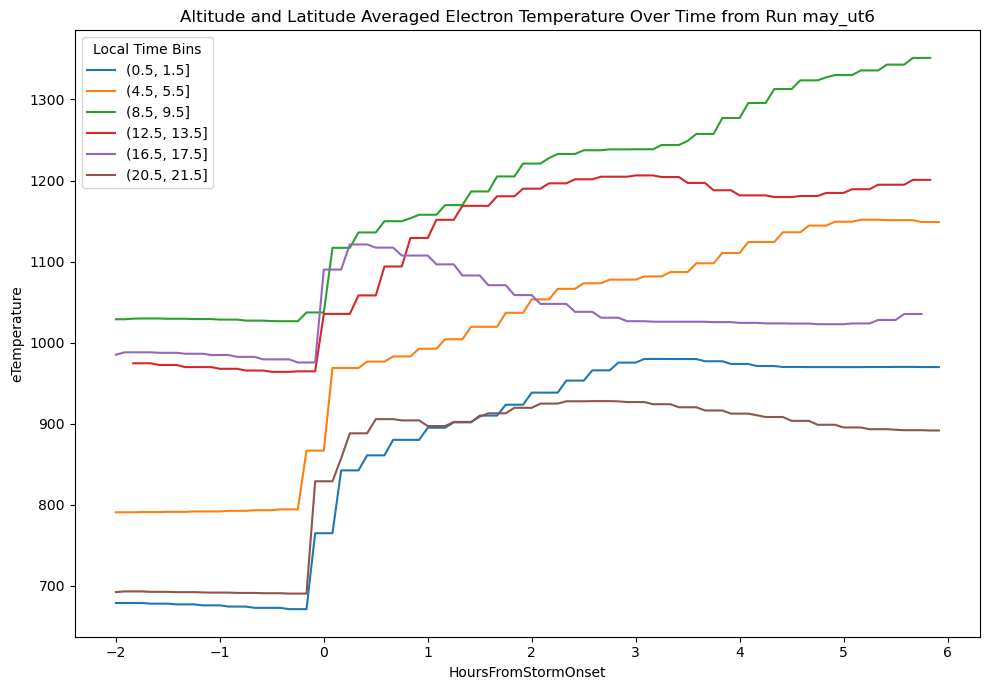

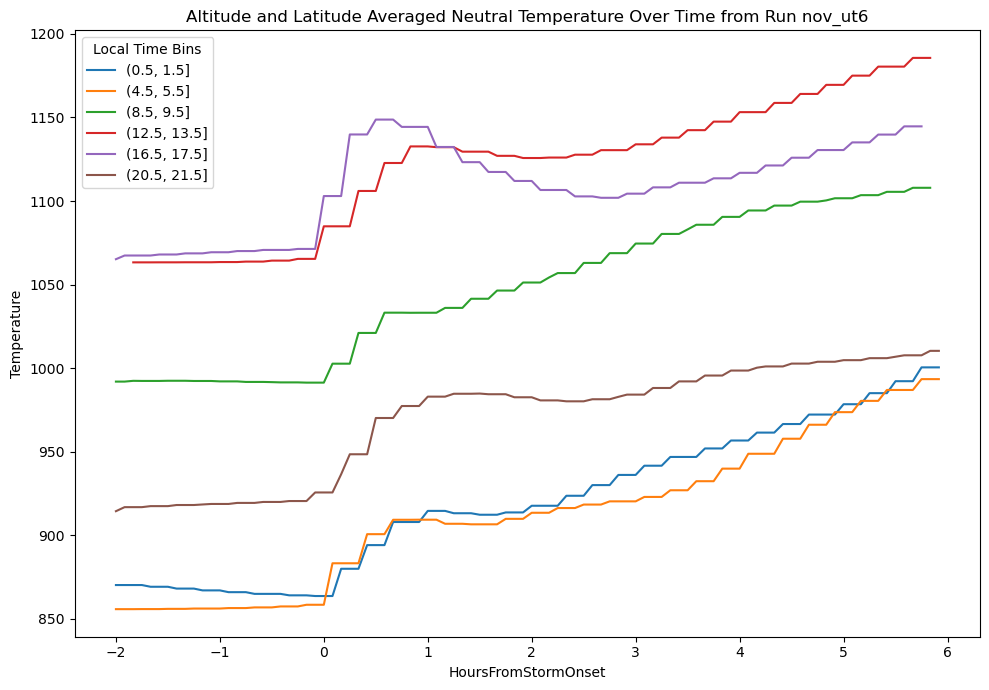

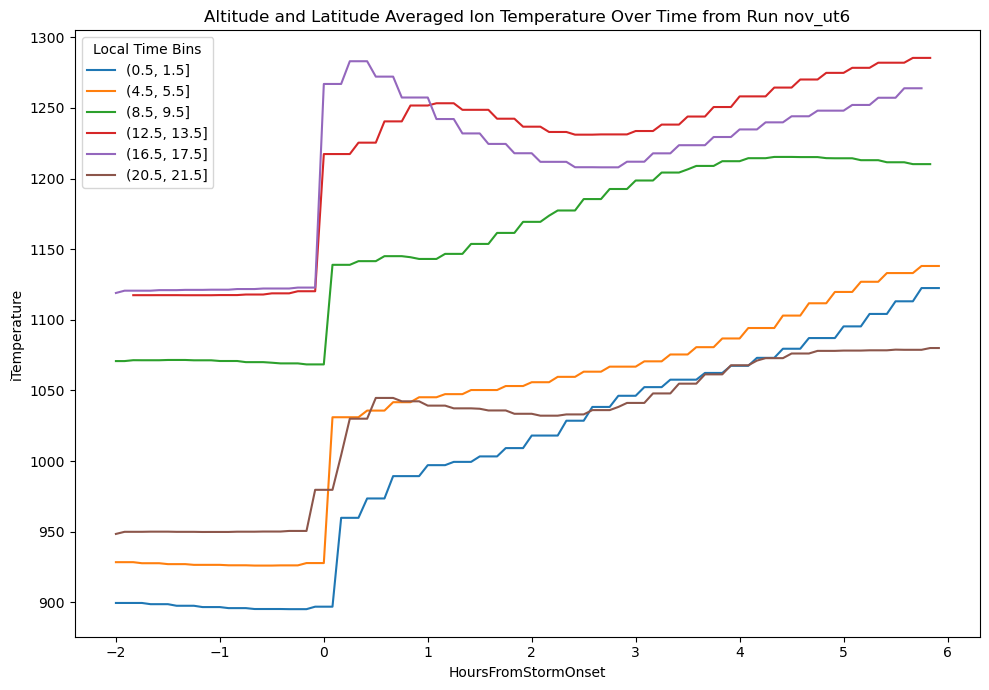

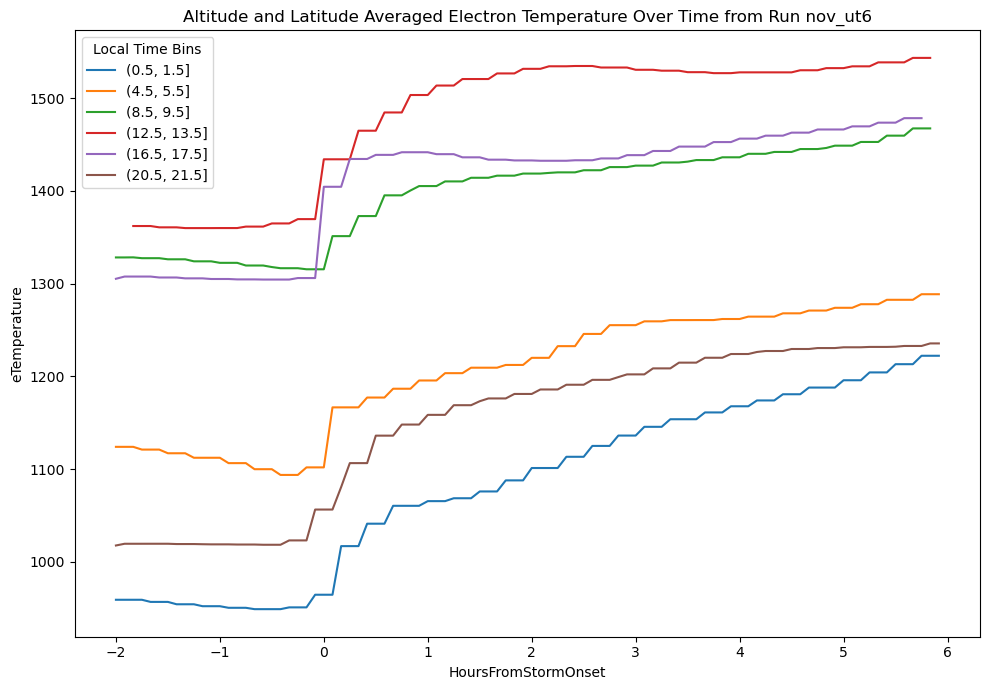

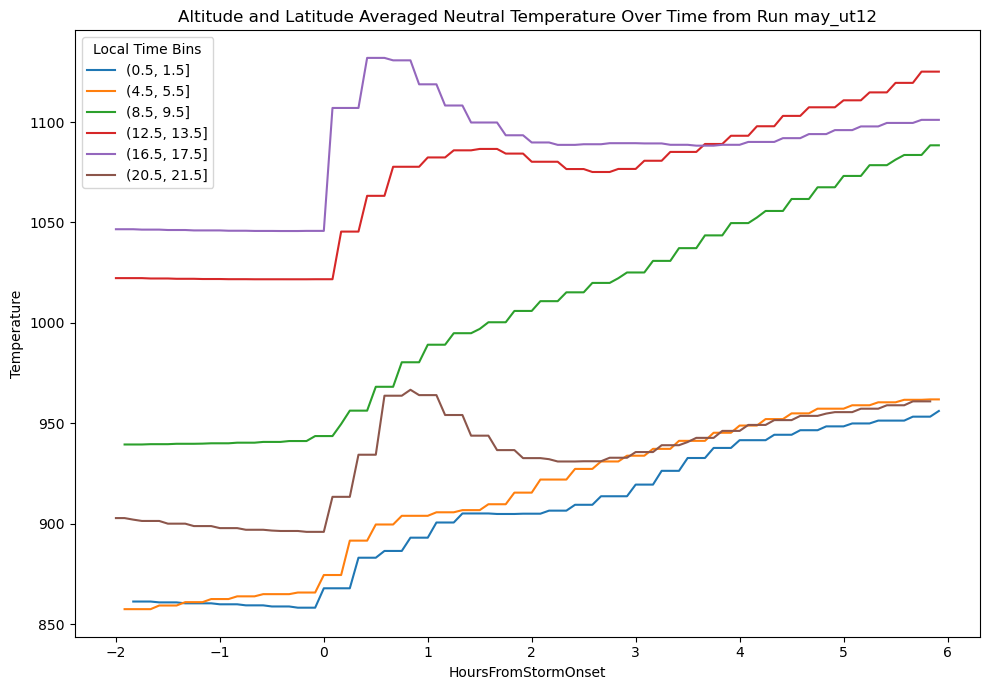

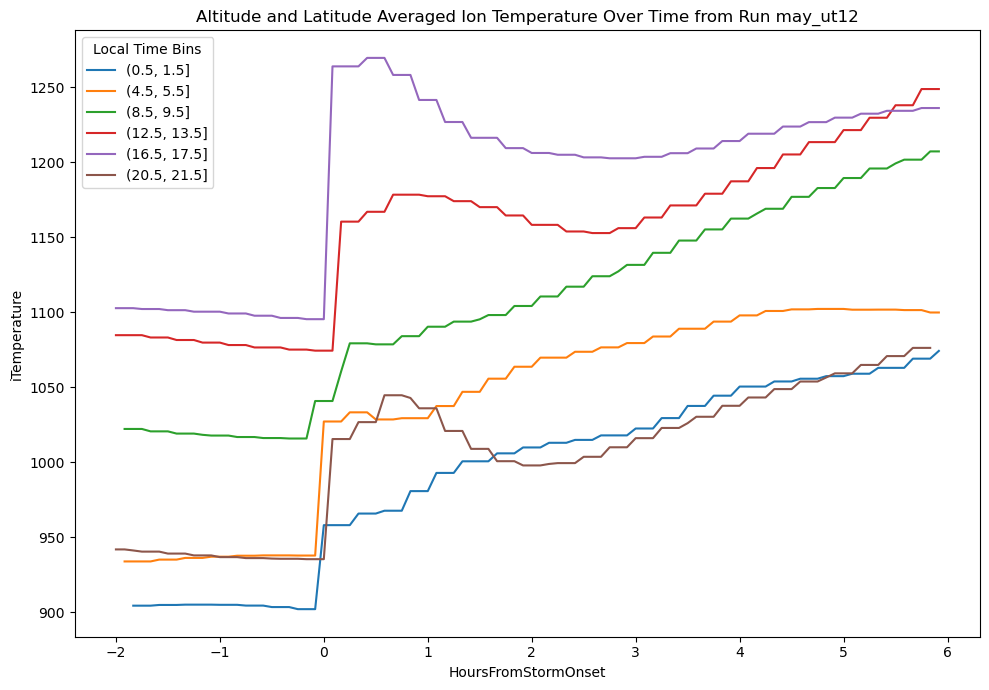

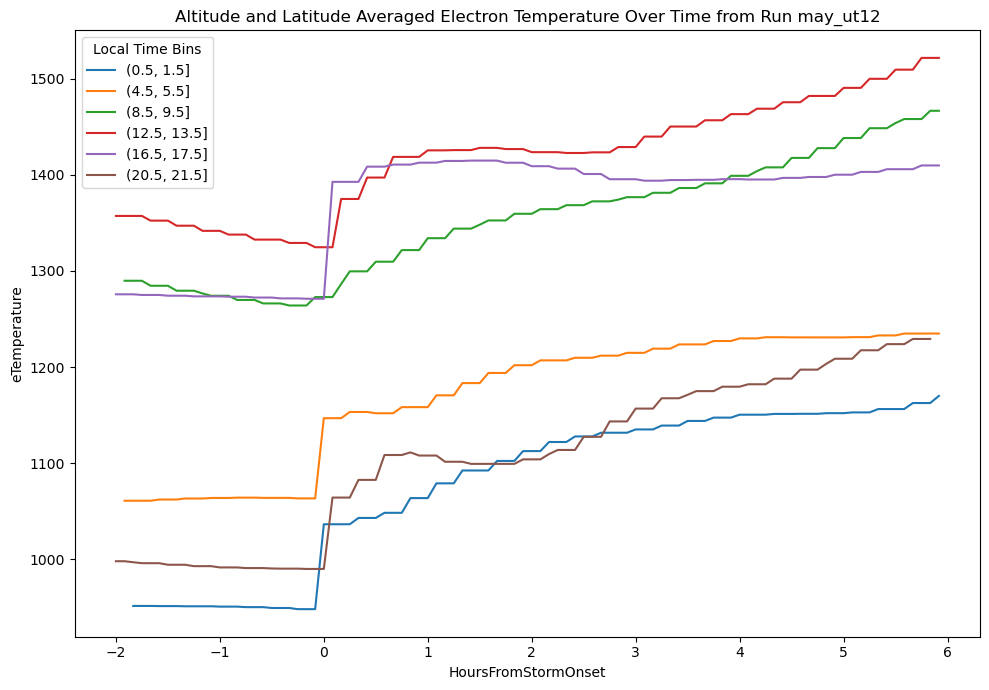

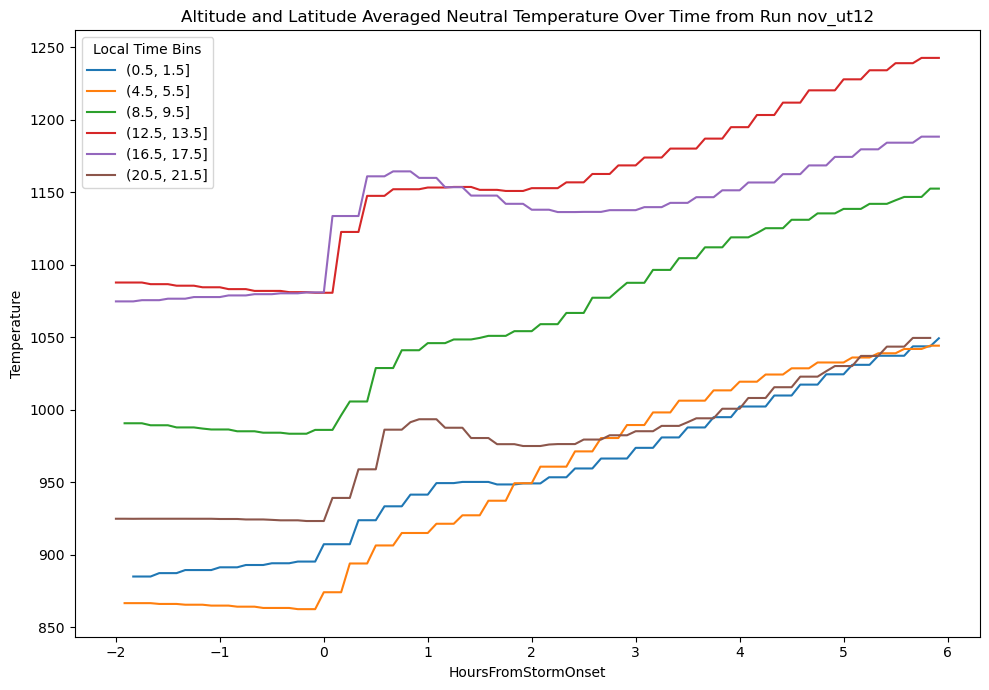

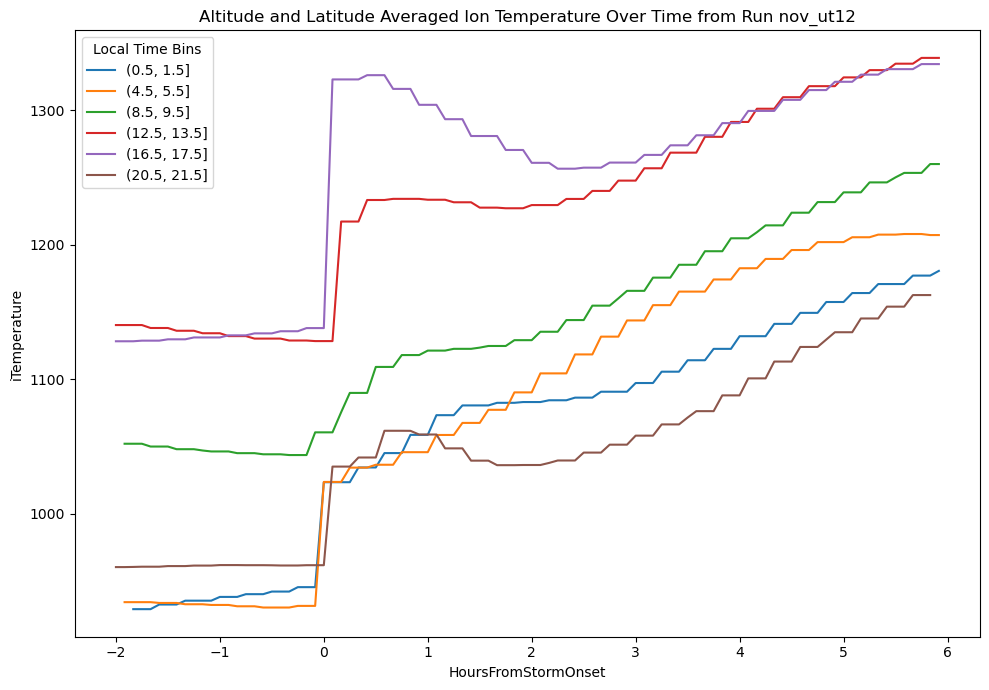

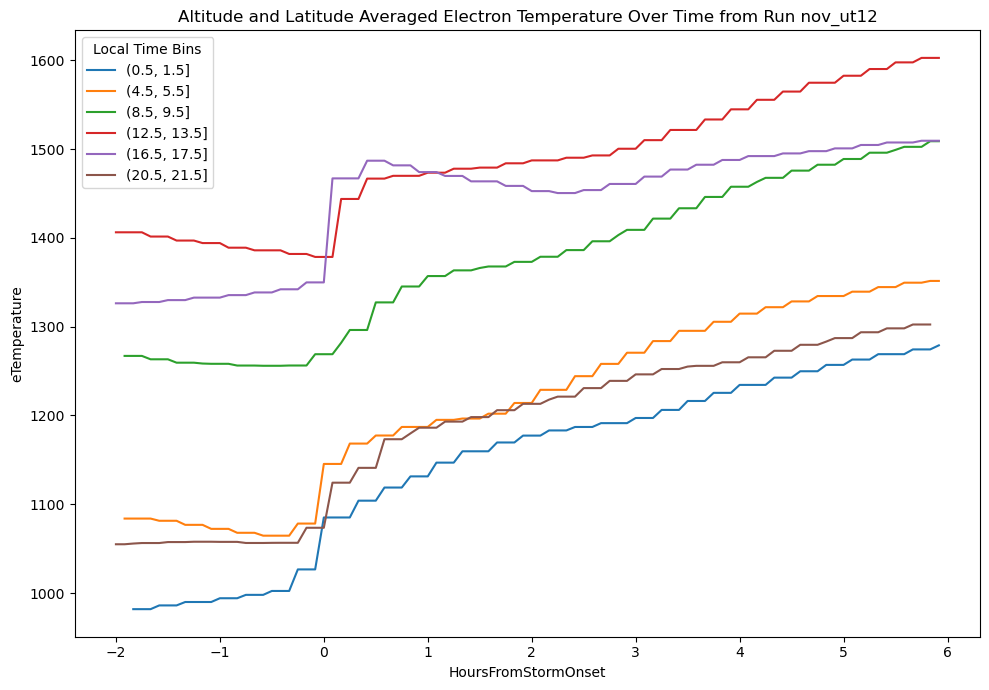

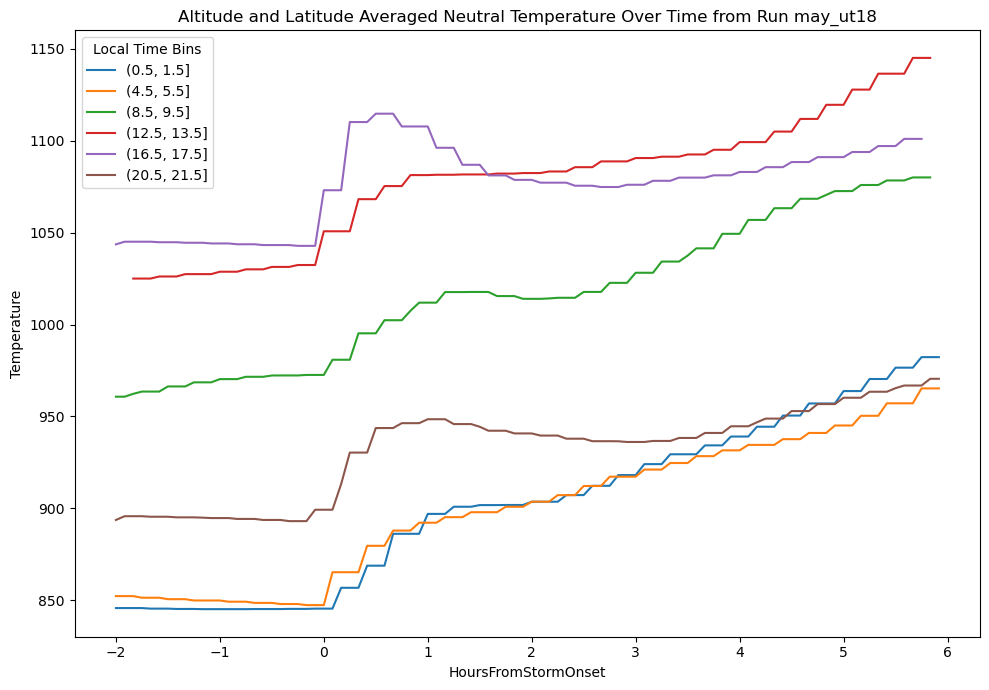

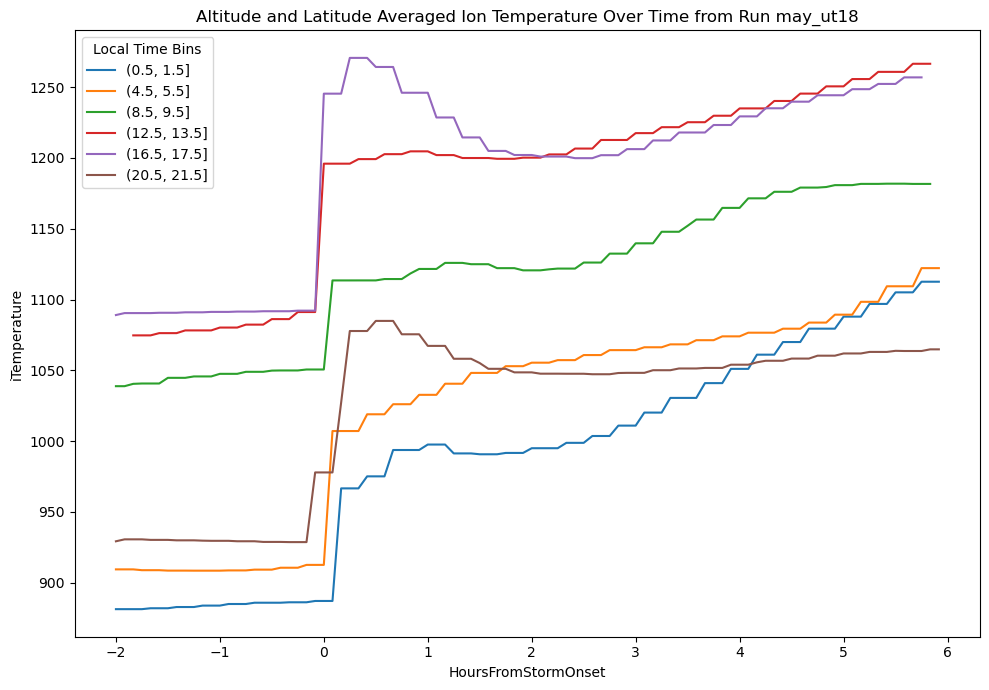

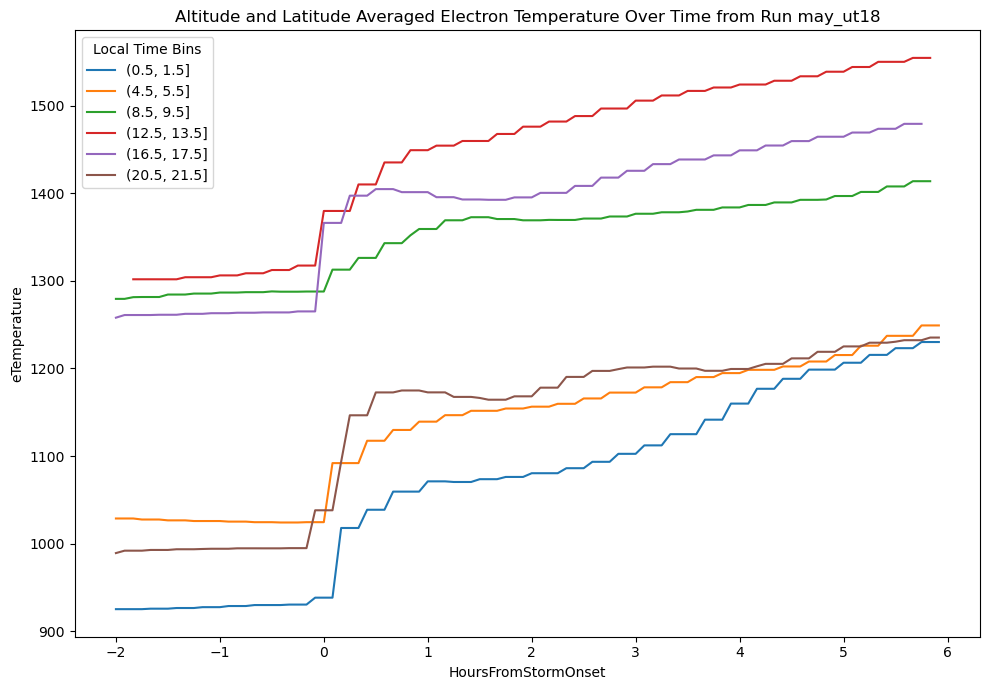

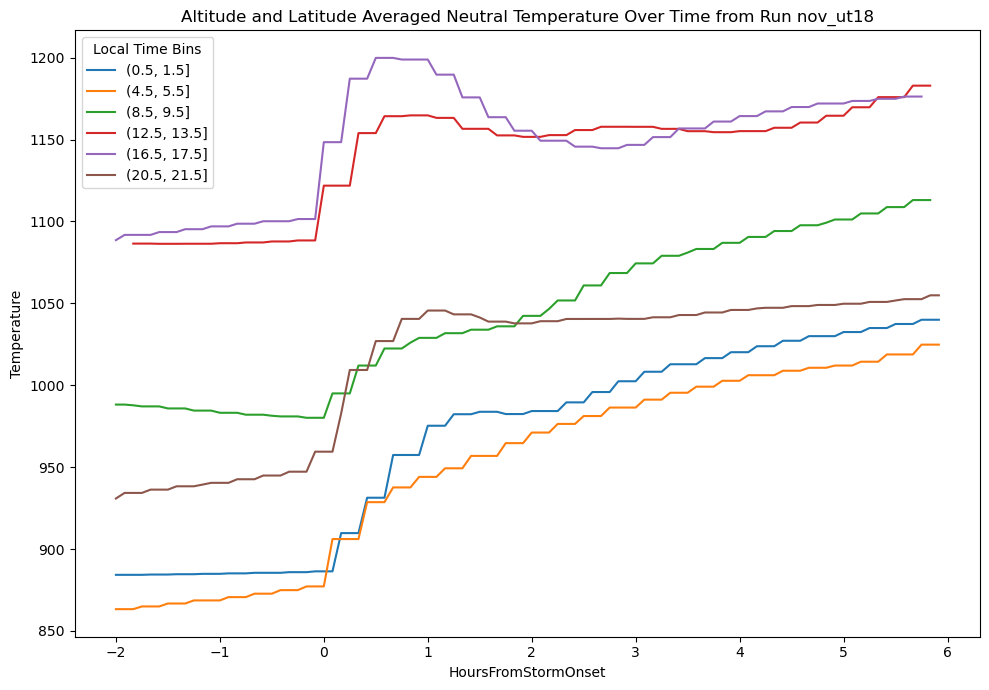

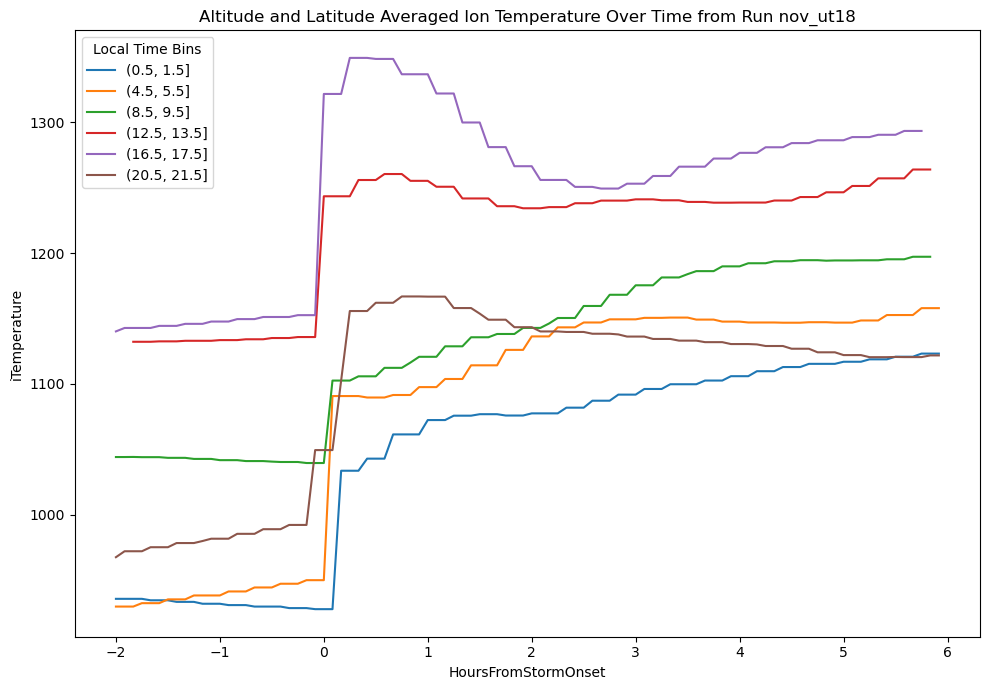

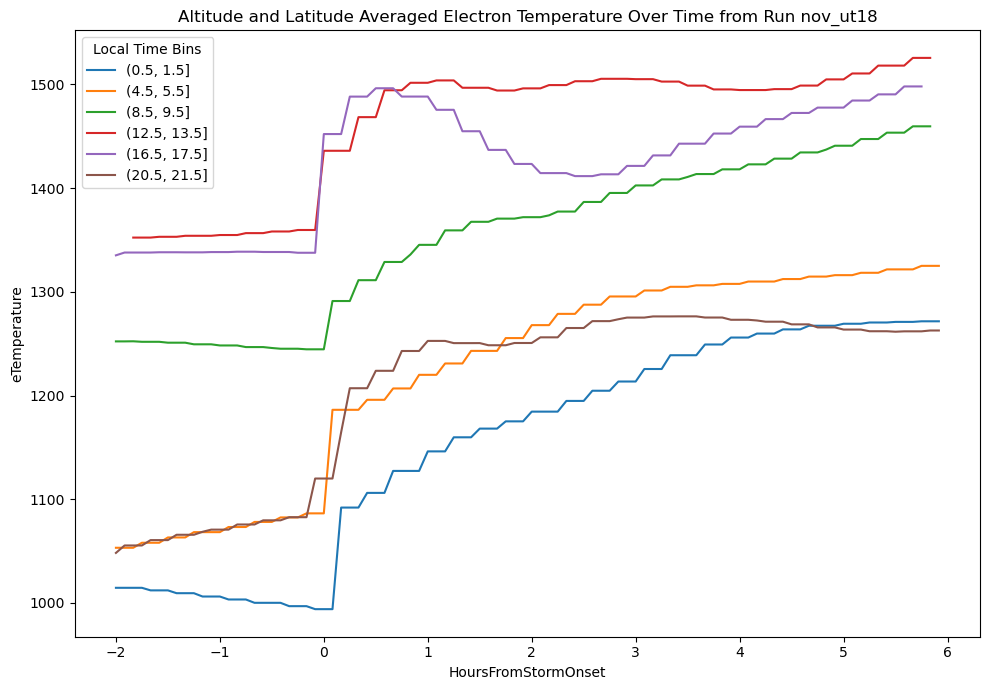

In [166]:
alts = [150, 250, 350, 450, 550, 650]


for run, gitm_ds in tqdm.tqdm(gitms.items()):
    
    for var in ['Temperature', 'iTemperature', 'eTemperature']:

        if var == 'Temperature':
            var_now = 'Neutral'
        elif var == 'eTemperature':
            var_now = 'Electron'
        elif var == 'iTemperature':
            var_now = 'Ion'
        else:
            raise ValueError
            
        for a in alts:

            ds = add_lt_to_dataset(gitm_ds[var].sel(alt=a, method='nearest').copy())
            group = ds.groupby_bins('localtime', bins=np.linspace(0.5,24.5,25))
            sels = list(group.groups.items())[::4]

            ds['HoursFromStormOnset'] = ((ds.time.dt.hour - (ds.time[0].dt.hour)) + (ds.time.dt.minute - (ds.time[0].dt.minute + 120))/60)

            plt.figure(figsize=(10,7))
            for vals, isels in sels:
                ds.isel(localtime=isels).mean('lat').mean('localtime').plot(x='HoursFromStormOnset', label=vals)

            plt.title("Latitude Averaged %s Temperature Over Time from Run %s" %(var_now, run)) 
            plt.legend(title='Local Time Bins')
            plt.tight_layout()
            plt.savefig('/glade/u/home/abukowski/plots/cedar/exploring/ut/temperature/lt_plots_at-alt/' + a + '-' + run + '_' + var)

In [170]:
run

'nov_ut18'

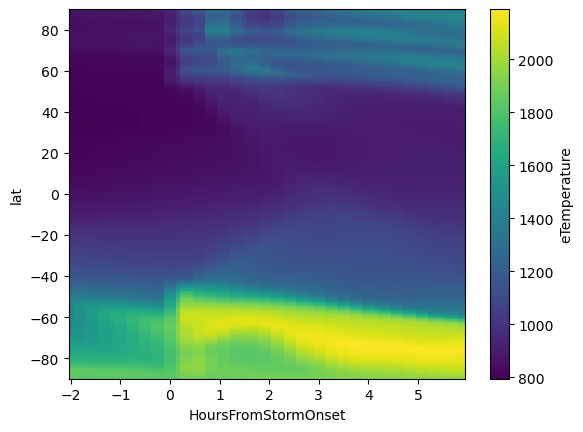

In [169]:
ds.isel(localtime=isels).mean('alt').mean('localtime').plot(x='HoursFromStormOnset', y='lat')

In [27]:
plotting_routines = importlib.reload(plotting_routines)

/glade/u/home/abukowski/SAMI3-GITM-python/utility_programs/plotting_routines.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
